# Hyperskill python dataset analysis

## Settings

In [22]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys
import os

import importlib

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [23]:
module_path = os.path.abspath(os.path.join('../../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import analysis
importlib.reload(analysis)

from analysis.src.python.data_analysis.analysis.attrs import draw_base_attrs

from analysis.src.python.data_analysis.analysis.statistics import \
    get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from analysis.src.python.data_analysis.analysis.plots import \
    draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

In [24]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

In [25]:
def get_tag(count, scope_borders, labels) -> str:
    if count <= scope_borders[0]:
        return labels[0]
    if count >= scope_borders[1]:
        return labels[2]
    return labels[1]

### Set path to following csv files (or use preset default)

In [26]:
data_directory_path = '/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/analysis/src/resources/data/python_new'
steps_file_path = os.path.join(data_directory_path, 'steps_prep.csv')
topics_file_path = os.path.join(data_directory_path, 'topics_prep.csv')

submissions_file_path = os.path.join(data_directory_path, 'solutions_python3_prep.csv')
submissions_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_stats.csv')

hyperstyle_issues_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_hyperstyle_filtered_issues.csv')
hyperstyle_issues_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_hyperstyle_filtered_issues_stats.csv')
hyperstyle_issues_classes_file_path = os.path.join(data_directory_path, 'hyperstyle_issues.csv')


### Color pallents of main attributes

difficulty
easy -> medium -> hard


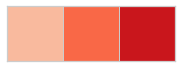

complexity
shallow -> middle -> deep


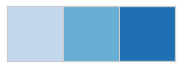

scope
small -> medium -> wide


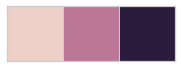

level
low -> average -> high


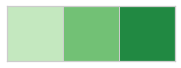

client
idea -> web


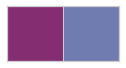

In [27]:
draw_base_attrs()

# Steps and Topics
**Step** - is a task where user is asked to write some code. Main attributes:
* `id` - *identifier of step*
* `seconds_to_complete` - *estimated secons to complete (calculated as average from all successful sumbissions)*
* `solved_by` - *number of successful sumbissions*
* `success_rate` - *number of successful sumbissions dvided by total number of sumbissions*
* `topic_id` - *id of topic step is related to. By this id we can define step's `depth` and `prerequisites_count` by related topic's `depth` and `prerequisites_count`*
* `difficulty` - [`easy`, `medium`, `hard`] *according to success_rate [sr<=0.33, 0.33<sr<0.66, sr>=0.66]*. This value is defeined in planform and calculated there for each step according this rule.
* `complexity` - [`shallow`, `middle`, `deep`] *according to topic depth [d<=2, 2<d<5, d>=5]*. Borders was selected as 0.25 and 0.75 quantiles.
* `scope` - [`small`, `medium`, `wide`] *according to prerequisites_count [pc<=6, 6<pc<42, pc>=42]*. Borders was selected as 0.25 and 0.75 quantiles.

**Topic** - is a theme or knowledge area. Every step is related to some topic. Main attributes:
* `id` - *identifier of step*
* `prerequisites` - *topics ids which must be leared before*
* `depth` - *the depth in topics tree*
* `prerequisites_count` - *number of all prerequisite topics in topics tree (subtree size)*

In [28]:
df_steps = pd.read_csv(steps_file_path)
df_steps[['id', 'success_rate', 'depth', 'prerequisites_count']].describe(percentiles=[0.25, 0.5, 0.75])

,id,success_rate,depth,prerequisites_count
count,364.000000,364.000000,364.000000,364.000000
mean,9051.164835,0.486664,3.810440,18.368132
std,2709.851774,0.144660,2.118995,19.314468
min,5205.000000,0.059000,0.000000,0.000000
25%,6718.250000,0.381750,2.000000,5.000000
50%,8440.500000,0.456500,3.500000,11.000000
75%,10791.250000,0.594320,5.000000,26.000000
max,15188.000000,0.885000,10.000000,78.000000


In [29]:
df_steps['complexity'] = df_steps['depth'].apply(get_tag, scope_borders=[2, 5], labels=['shallow', 'middle', 'deep'])
df_steps['scope'] = df_steps['prerequisites_count'].apply(get_tag, scope_borders=[5, 26], labels=['small', 'medium', 'wide'])
df_steps.to_csv(steps_file_path, index=False)

## Steps statistics description

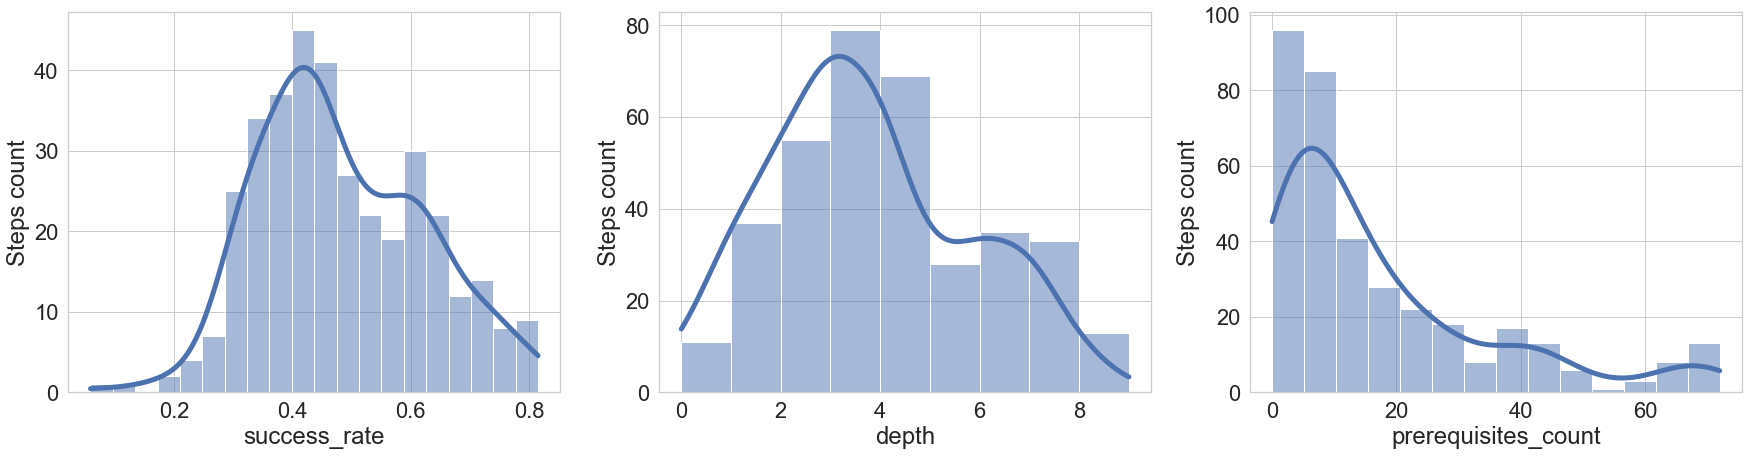

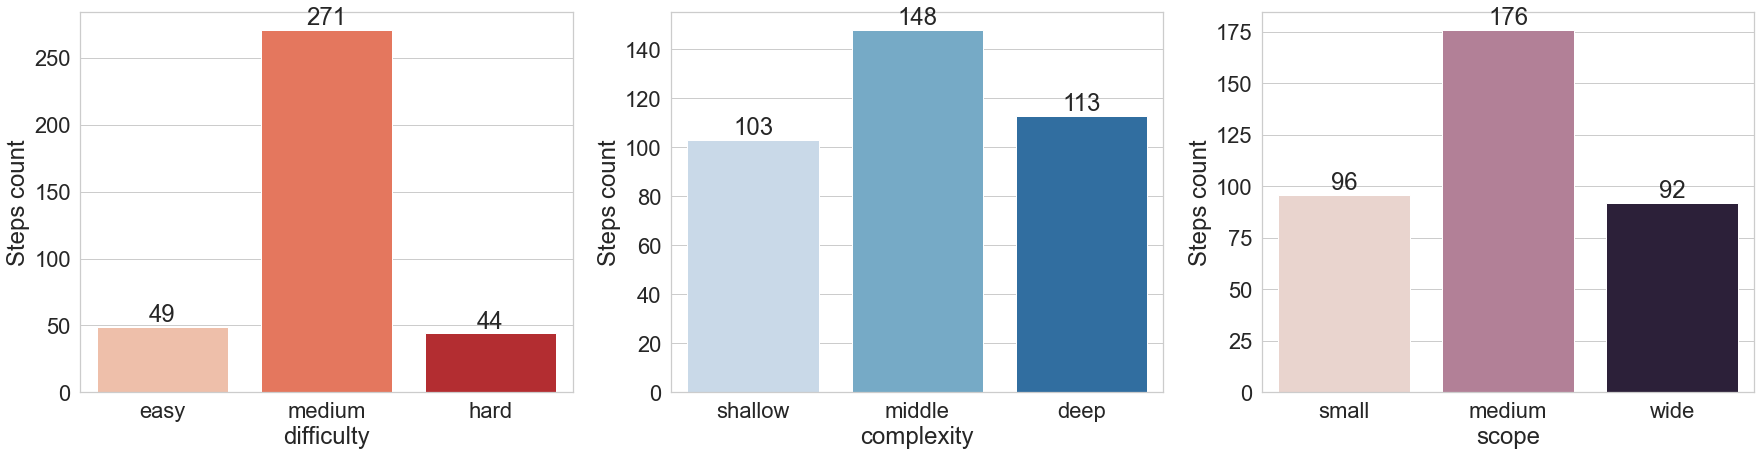

In [30]:
draw_hist_plots(df_steps, ['success_rate', 'depth', 'prerequisites_count'], 
                columns=3, log_scale=False, kde=True, y_label='Steps count')
draw_count_plots(df_steps, ['difficulty', 'complexity', 'scope'], 
                 columns=3, y_label='Steps count')

## Submissions

Submission is an attempt of user to pass step's task. One user can do several attempts to pass one step.

* `id` - *identifier of submission*
* `step_id` - *identifier of step*
* `user_id` - *identifier of user*
* `group` - *number of submission series (group of submissions on one step by one user)*
* `attempt` - *number of attempt inside submission series*
* `total_attempt` - *number of attempts is submission series*
* `base_client` - `[web, idea, ide, IdeaEdu, Idea]` *interface from which submission was submitted*
* `client` - `[web, idea]` *interface group from which submission was submitted*

In [31]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.describe()

,id,step_id,sync_counter,user_id,group,attempt,total_attempts
count,1.404532e+06,1.404532e+06,1.404532e+06,1.404532e+06,1.404532e+06,1.404532e+06,1.404532e+06
mean,4.299687e+07,7.106596e+03,4.809562e+00,4.933600e+04,8.212245e+05,1.379840e+01,2.659679e+01
std,7.727498e+06,1.467019e+03,1.038248e+00,1.780248e+04,4.841512e+05,1.236126e+02,2.136905e+02
min,2.938133e+07,5.205000e+03,1.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
25%,3.629623e+07,6.345000e+03,4.000000e+00,4.254900e+04,4.069958e+05,1.000000e+00,1.000000e+00
50%,4.304991e+07,6.737000e+03,5.000000e+00,5.207100e+04,8.219550e+05,1.000000e+00,1.000000e+00
75%,4.981060e+07,7.468000e+03,5.000000e+00,6.058500e+04,1.218373e+06,1.000000e+00,2.000000e+00
max,5.639778e+07,1.518800e+04,1.900000e+01,8.240000e+04,1.722704e+06,3.347000e+03,3.347000e+03


In [32]:
print('submissions:', df_submissions.shape[0])
print('users:', df_submissions['user_id'].unique().shape[0])
print('steps:', df_submissions['step_id'].unique().shape[0])
print('series:', df_submissions[df_submissions['attempt'] == 1].shape[0])

submissions: 1404532
users: 46867
steps: 364
series: 1155524


In [33]:
total_attempt_count = {
    'total_attempts': [],
    'count<=': [],
    'count>': [],
    'percent<=': [],
    'percent>': [],
}


for total_attempt in sorted(df_submissions['total_attempts'].unique()):
    total_attempt_count['total_attempts'].append(total_attempt)
    count = df_submissions[df_submissions['total_attempts'] <= total_attempt].shape[0]
    total_attempt_count['count<='].append(count)
    total_attempt_count['count>'].append(df_submissions.shape[0] - count)
    total_attempt_count['percent<='].append(count / df_submissions.shape[0])
    total_attempt_count['percent>'].append((df_submissions.shape[0] - count) / df_submissions.shape[0])

df_total_attempt_count = pd.DataFrame.from_dict(total_attempt_count)
df_total_attempt_count.to_csv('python/total_attempts.csv', index=False)
df_total_attempt_count

,total_attempts,count<=,count>,percent<=,percent>
0,1,1010454,394078,0.719424,0.280576
1,2,1222282,182250,0.870241,0.129759
2,3,1297033,107499,0.923463,0.076537
3,4,1329557,74975,0.946619,0.053381
4,5,1345332,59200,0.957851,0.042149
...,...,...,...,...,...
129,1352,1395804,8728,0.993786,0.006214
130,1698,1397502,7030,0.994995,0.005005
131,1739,1399241,5291,0.996233,0.003767
132,1944,1401185,3347,0.997617,0.002383


# Filter all submissions with > 5 total attempts

In [34]:
df_submissions = df_submissions[df_submissions['total_attempts'] <= 5]
df_submissions.describe()

,id,step_id,sync_counter,user_id,group,attempt,total_attempts
count,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06
mean,4.292182e+07,7.089858e+03,4.810385e+00,5.065179e+04,8.429489e+05,1.194005e+00,1.388010e+00
std,7.704249e+06,1.459950e+03,1.038372e+00,1.616353e+04,4.721067e+05,5.372738e-01,7.964588e-01
min,2.938133e+07,5.205000e+03,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
25%,3.626600e+07,6.319000e+03,4.000000e+00,4.336500e+04,4.413668e+05,1.000000e+00,1.000000e+00
50%,4.292694e+07,6.737000e+03,5.000000e+00,5.244000e+04,8.430660e+05,1.000000e+00,1.000000e+00
75%,4.968532e+07,7.458000e+03,5.000000e+00,6.089200e+04,1.229866e+06,1.000000e+00,1.000000e+00
max,5.639778e+07,1.518800e+04,1.900000e+01,8.240000e+04,1.722704e+06,5.000000e+00,5.000000e+00


In [35]:
print('submissions:', df_submissions.shape[0])
print('users:', df_submissions['user_id'].unique().shape[0])
print('steps:', df_submissions['step_id'].unique().shape[0])
print('series:', df_submissions[df_submissions['attempt'] == 1].shape[0])

submissions: 1345332
users: 46863
steps: 364
series: 1152571


### Sumbission client distriburion
In platform student can use `web` indeface for typing code or `ide`.
This plot shows that around 2/3 of the sumbisssions are done in `web` indeface. 

<AxesSubplot:xlabel='client', ylabel='Count'>

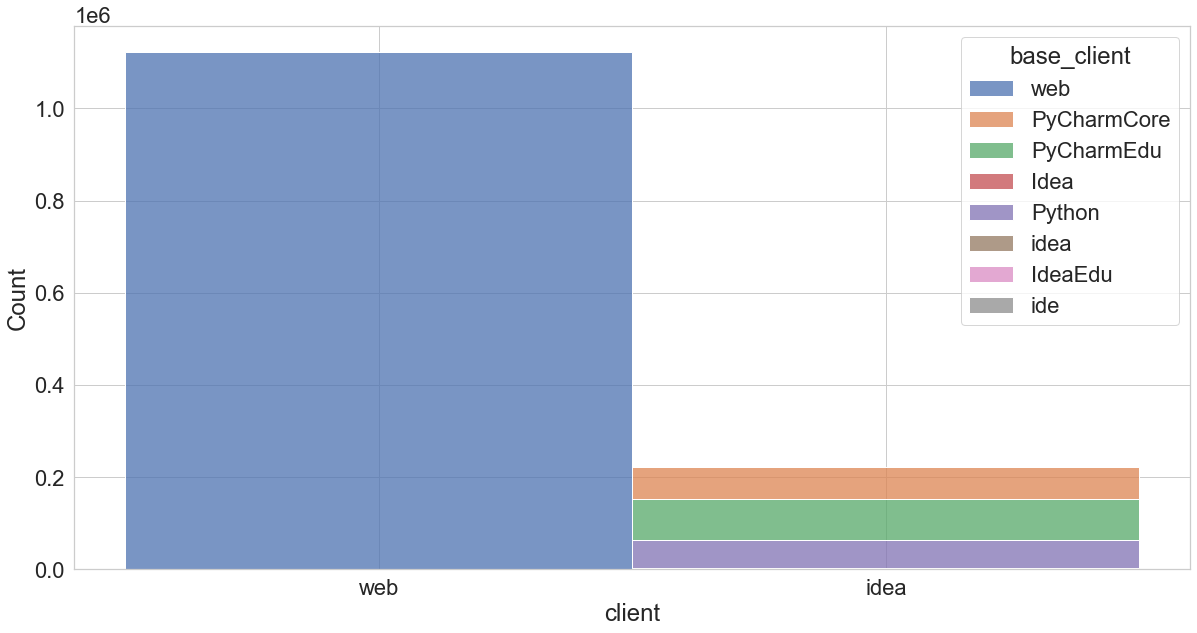

In [36]:
fig, ax = plt.subplots(figsize=((20, 10)))
sns.histplot(data=df_submissions, x='client', hue='base_client', multiple='stack')

## Submission statistics
* `code_lines_count` - number of code lines
* `code_symbols_count` - number of code symbols

In [37]:
df_submissions_stats = pd.read_csv(submissions_stats_file_path)
df_submissions_stats = df_submissions_stats[df_submissions_stats['id'].isin(df_submissions['id'])]
df_submissions_stats.describe().astype('int32')

,id,code_lines_count,code_symbols_count
count,1345332,1345332,1345332
mean,42921818,5,119
std,7704249,4,116
min,29381330,1,8
25%,36266000,2,45
50%,42926943,4,86
75%,49685322,7,154
max,56397784,128,4948


In [38]:
df_submissions_stats = merge_dfs(df_submissions_stats, df_submissions, left_on='id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_steps[['id', 'complexity', 'difficulty', 'scope']], left_on='step_id', right_on='id')

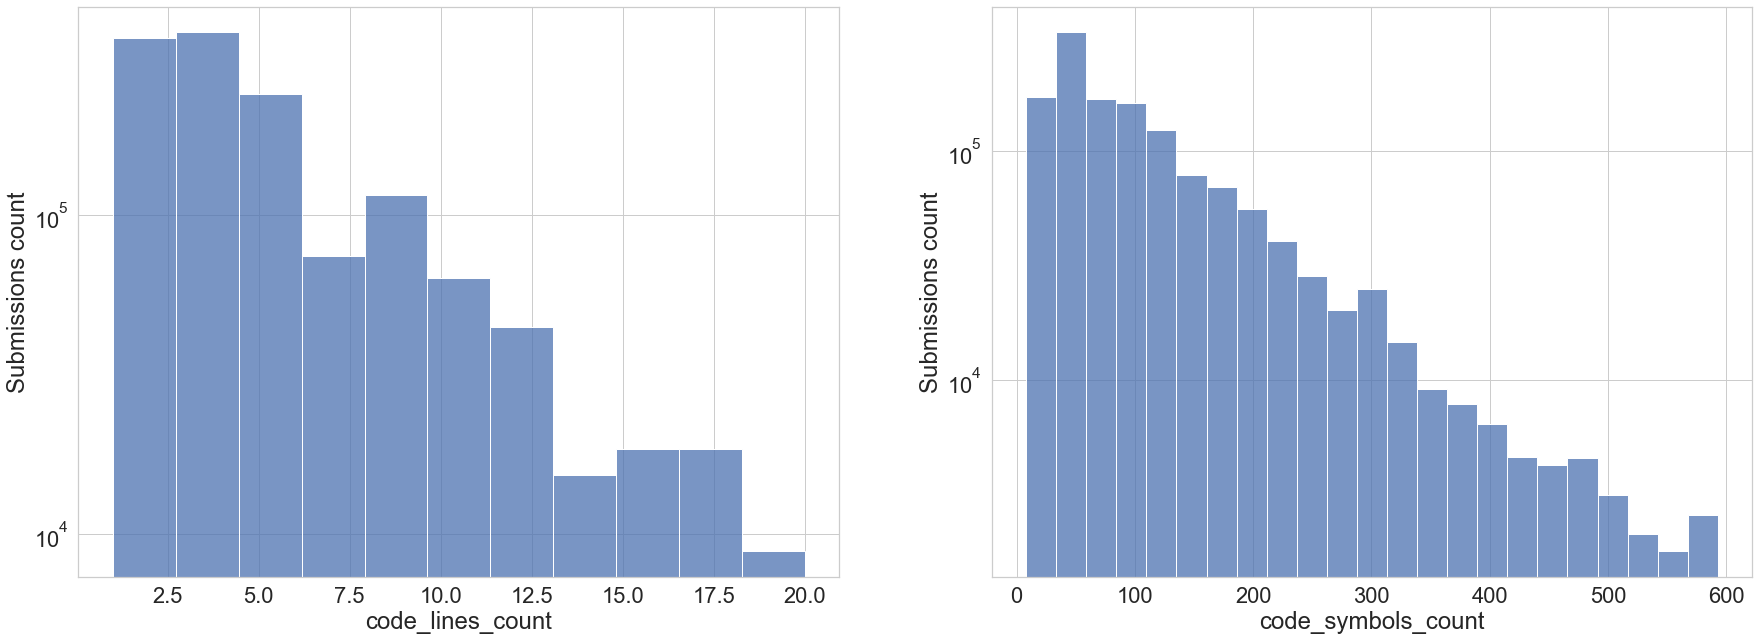

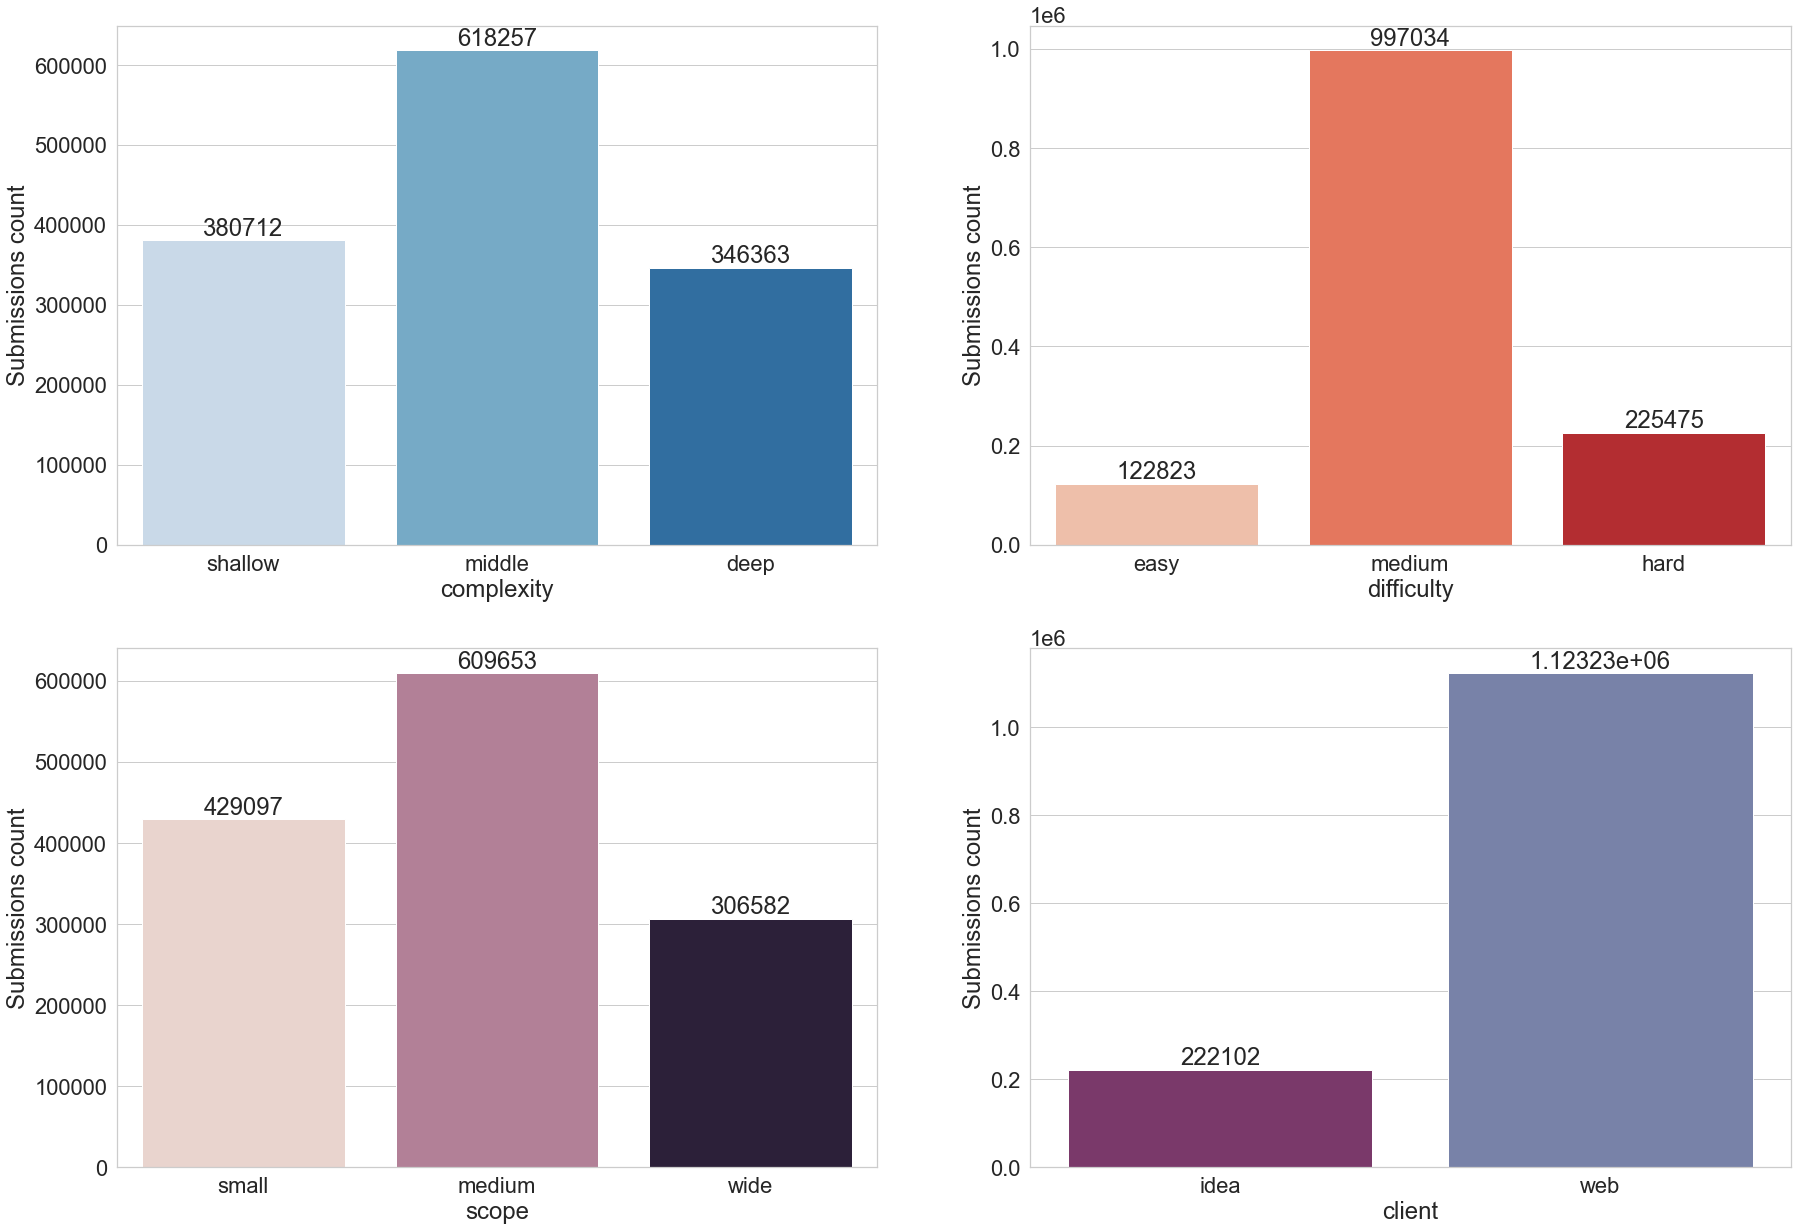

In [39]:
draw_hist_plots(df_submissions_stats, ['code_lines_count', 'code_symbols_count'], 
                columns=2, log_scale=(False, True), y_label='Submissions count')

draw_count_plots(df_submissions_stats, ['complexity', 'difficulty', 'scope', 'client'], y_label='Submissions count')

# Hyperstyle code quality issue analysis

We invoked Hyperstyle code quality tool on each submissions and got a code quality report with list of detected issues in submission `hypertyle_issues`. Hyperstyle issue is code quality error which has `name` e.x. MagicNumberCheck and `category` e.x. INFO. 

In a preprocessing part for each submission we calcaulated number of hypertyle issues of each name.

In [40]:
def draw_issues(df: pd.DataFrame, df_issues: pd.DataFrame, blur_issues, base_dir: str = 'results'):
    os.makedirs(base_dir, exist_ok=True)
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_stats = get_submissions_percent_by_issues(df, df_issues, attr, sort=False)
        df_stats.to_csv(os.path.join(base_dir, f'issues_stats_{attr}.csv'), index=False)
        draw_compare(df_stats, 
                     'issue', 
                     attr, blur_issues, 
                     save_path=os.path.join(base_dir, f'issues_stats_{attr}.png'))

In [41]:
df_hyperstyle_issues_stats = pd.read_csv(hyperstyle_issues_stats_file_path)
df_hyperstyle_issues_stats = df_hyperstyle_issues_stats[df_hyperstyle_issues_stats['id'].isin(df_submissions['id'])]
df_hyperstyle_issues_stats.describe()

,id,SC200,WPS432,E226,E231,E225,WPS336,E265,E211,W0311,...,E721,WPS311,E743,E1102,W0223,WPS522,WPS219,WPS338,R1704,WPS456
count,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,...,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1345332.0,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06,1.345332e+06
mean,4.292182e+07,3.067444e-01,2.074098e-01,7.315072e-02,5.544282e-02,5.076219e-02,3.499434e-02,3.015315e-02,1.835532e-02,1.342048e-02,...,7.433109e-07,7.433109e-07,7.433109e-07,7.433109e-07,0.0,7.433109e-07,7.433109e-07,7.433109e-07,7.433109e-07,7.433109e-07
std,7.704249e+06,1.518779e+00,9.498807e-01,4.859322e-01,6.908922e-01,3.895867e-01,3.372046e-01,2.503708e-01,1.958264e-01,2.572182e-01,...,8.621548e-04,8.621548e-04,8.621548e-04,8.621548e-04,0.0,8.621548e-04,8.621548e-04,8.621548e-04,8.621548e-04,8.621548e-04
min,2.938133e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.626600e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.292694e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.968532e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.639778e+07,9.600000e+01,3.400000e+01,2.400000e+01,4.750000e+02,4.100000e+01,2.400000e+01,2.600000e+01,1.700000e+01,3.800000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [42]:
df_hyperstyle_issues_stats = merge_dfs(df_hyperstyle_issues_stats, df_submissions_stats, left_on='id', right_on='id')

During the analysis we desided to filter out issues with `INFO` and `CODE_STYLE` categories and focude on `BEST_PRACTICES `and `ERROR_PRONE`.

In [43]:
df_hyperstyle_issues = pd.read_csv(hyperstyle_issues_classes_file_path)

hyperstyle_issues_wrong_names = ['R0801', 'WPS453', 'WPS226']
hyperstyle_issues_info_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                if issue['category'] == 'INFO']

hyperstyle_issues_ignore_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                   if issue['category'] == 'INFO' or issue['category'] == 'CODE_STYLE' or \
                                   issue['name'] in hyperstyle_issues_wrong_names]

hyperstyle_issues_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                            if issue['name'] not in hyperstyle_issues_ignore_names
                          ]

In one submission can be several issues with one name. But it is simplier to analyse only the presence/absence on issue in solution so in `_unique` dataframe we replace issue count to 0/1 value (0-no such issue in this submission, 1-one ore more issues are detected in this submission).

In [44]:
# Unique means a flag: 1 if issue presented in submission, 0 otherwise
df_hyperstyle_issues_stats_unique = df_hyperstyle_issues_stats.copy()
for issue_name in df_hyperstyle_issues['name'].values:
    df_hyperstyle_issues_stats_unique[issue_name] = df_hyperstyle_issues_stats_unique[issue_name] \
        .apply(lambda x: min(x, 1))

In [45]:
BASE_PATH = os.path.join('python', 'hyperstyle')
IGNORE_ISSUES_STATS_PATH = os.path.join(BASE_PATH, 'ignore_issues_stats')
ISSUES_STATS_PATH = os.path.join(BASE_PATH, 'issues_stats')

FIRST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'first_attempt_stats')
LAST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'last_attempt_stats')
FIRST_LAST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'first_last_attempt_stats')

ISSUES_DYNAMIC_STATS_PATH = os.path.join(BASE_PATH, 'issues_dynamic_stats')


os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IGNORE_ISSUES_STATS_PATH, exist_ok=True)
os.makedirs(ISSUES_STATS_PATH, exist_ok=True)
os.makedirs(FIRST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(LAST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(FIRST_LAST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(ISSUES_DYNAMIC_STATS_PATH, exist_ok=True)

### List and analysis of ignored (filtered) issues (with CODE_STYLE and INFO categories)

In [46]:
df_hyperstyle_ignore_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                                 df_hyperstyle_issues, 
                                                 20, 
                                                 hyperstyle_issues_names)
df_hyperstyle_ignore_issues_top.to_csv(os.path.join(IGNORE_ISSUES_STATS_PATH, f'top_issues.csv'), index=False)
df_hyperstyle_ignore_issues_top

,name,count,category,text,difficulty,code_sample,ratio
1,WPS432,123156,INFO,Found magic number: 1234567890. The use of unn...,EASY,print((1234567890 * 987654321) + 67890) # WPS4...,0.091543
0,SC200,87958,INFO,Possibly misspelt word: 'num1',EASY,num1 = int(input()) # SC200 line=1 offset=1\nn...,0.065380
2,E226,55793,CODE_STYLE,missing whitespace around arithmetic operator,EASY,# put your python code here\nmarks = input()\n...,0.041472
4,E225,39498,CODE_STYLE,missing whitespace around operator,EASY,# Make sure your output matches the assignment...,0.029359
3,E231,31923,CODE_STYLE,"missing whitespace after ','",EASY,import math\n\nn = int(input())\nlist = []\ni ...,0.023729
6,E265,20939,CODE_STYLE,block comment should start with '# ',EASY,#print(1 + 2 + 3 + 6) # E265 line=1 offset=1\n...,0.015564
7,E211,18320,CODE_STYLE,whitespace before '(',EASY,"input1 = int(input(""""))\ninput2 = int(input(""""...",0.013617
14,E202,8893,CODE_STYLE,whitespace before ')',EASY,# put your python code here\nnumber = int(inpu...,0.006610
28,C0305,7678,CODE_STYLE,Trailing newlines,EASY,"class Person:\n def __init__(self, name):\n...",0.005707
19,E201,7581,CODE_STYLE,whitespace after '{',EASY,"HAND_COUNT = 6\n\nface_cards = { 'Ace': ""14"", ...",0.005635


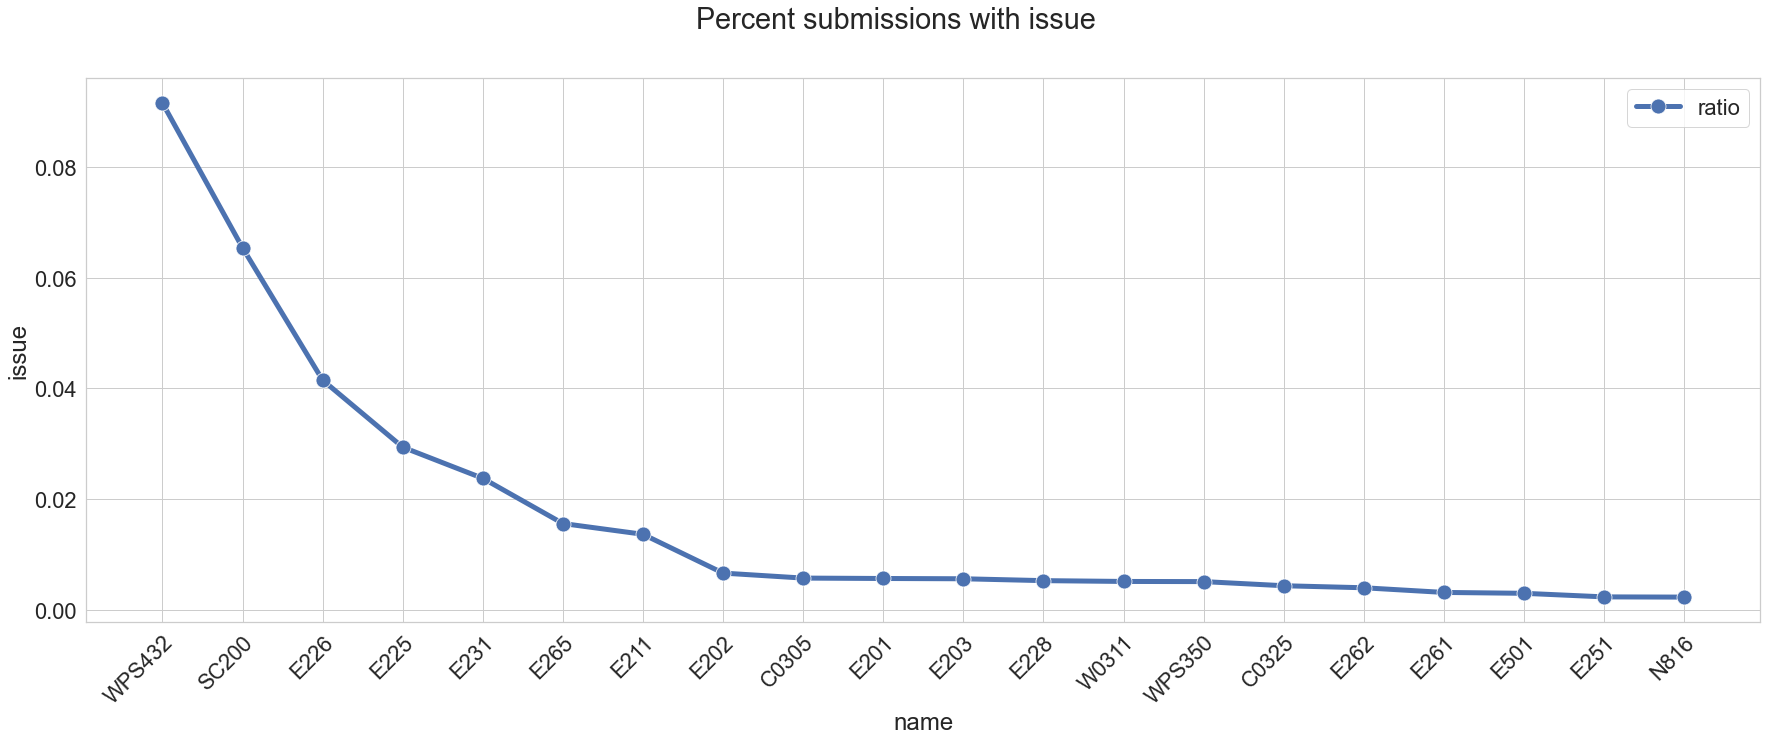

In [47]:
draw_compare(df_hyperstyle_ignore_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent submissions with issue', 
             save_path=os.path.join(IGNORE_ISSUES_STATS_PATH, f'top_issues.pdf'))

### Persent of submissions which contains each code quality `ignored` issue 

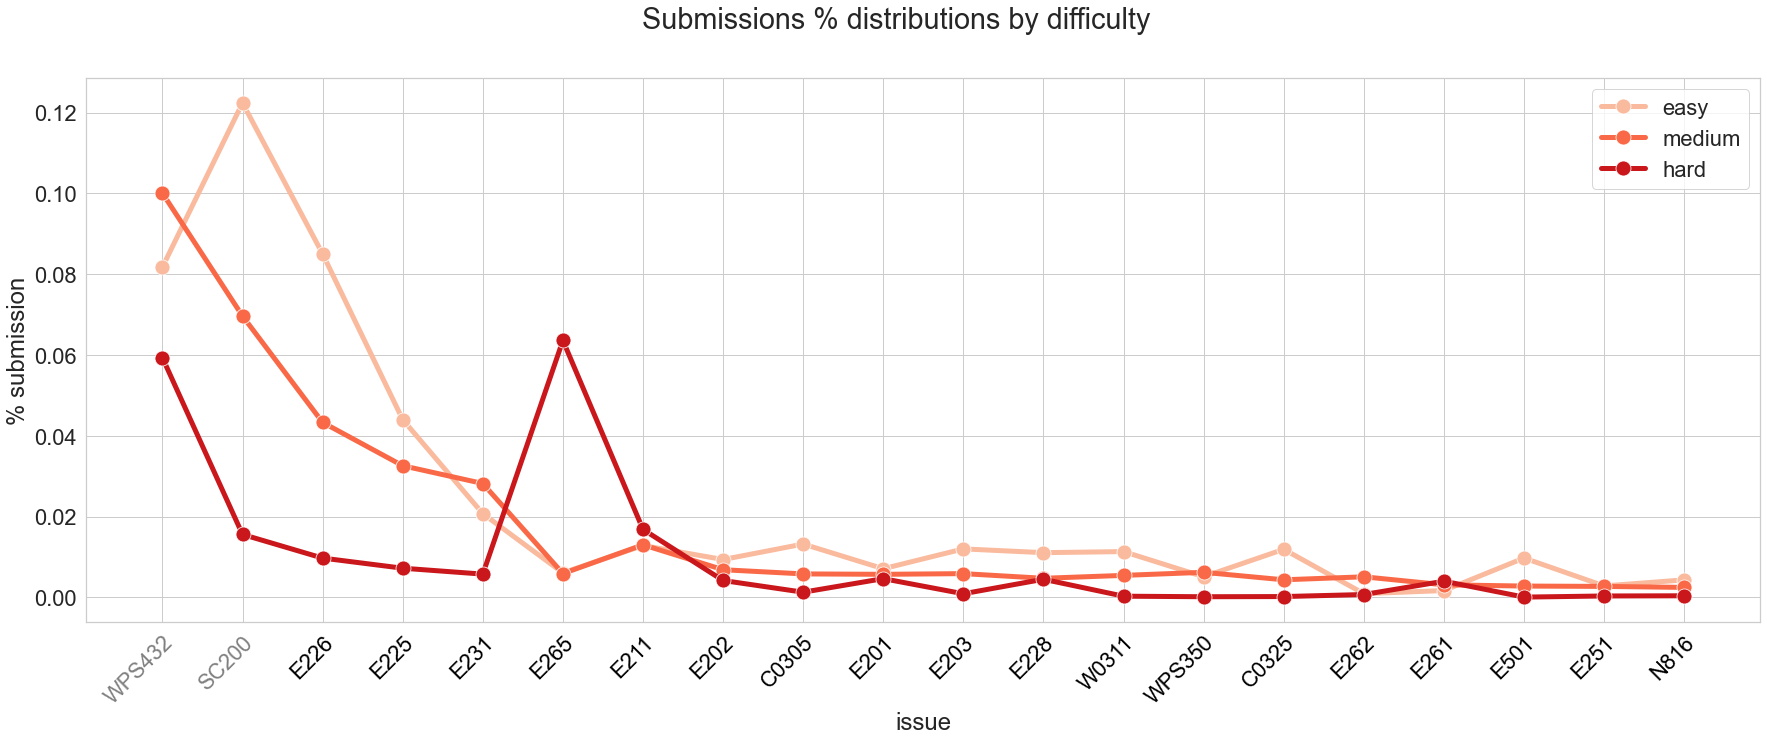

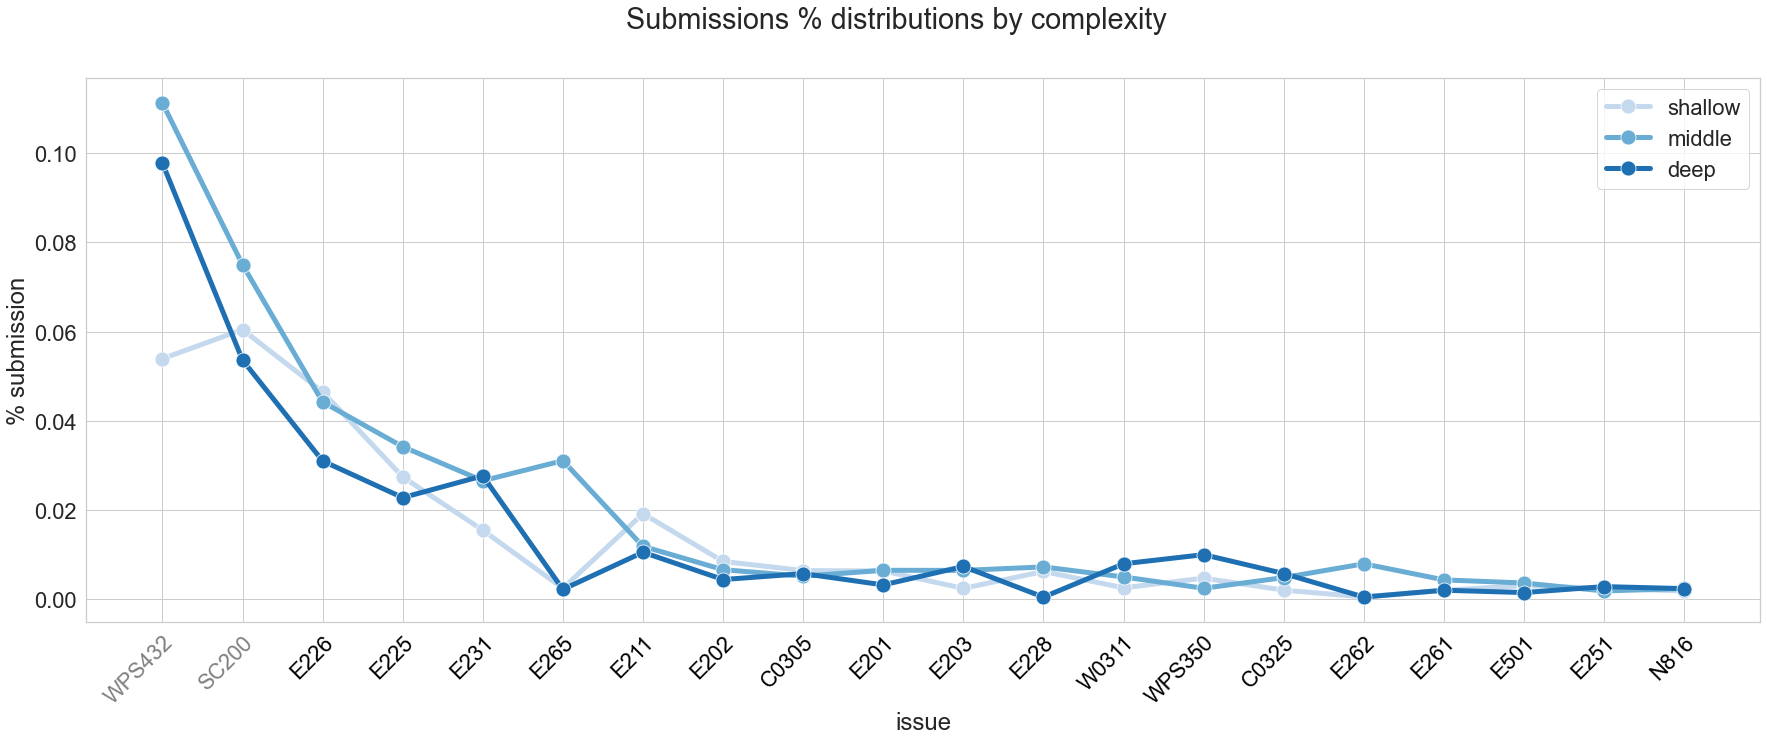

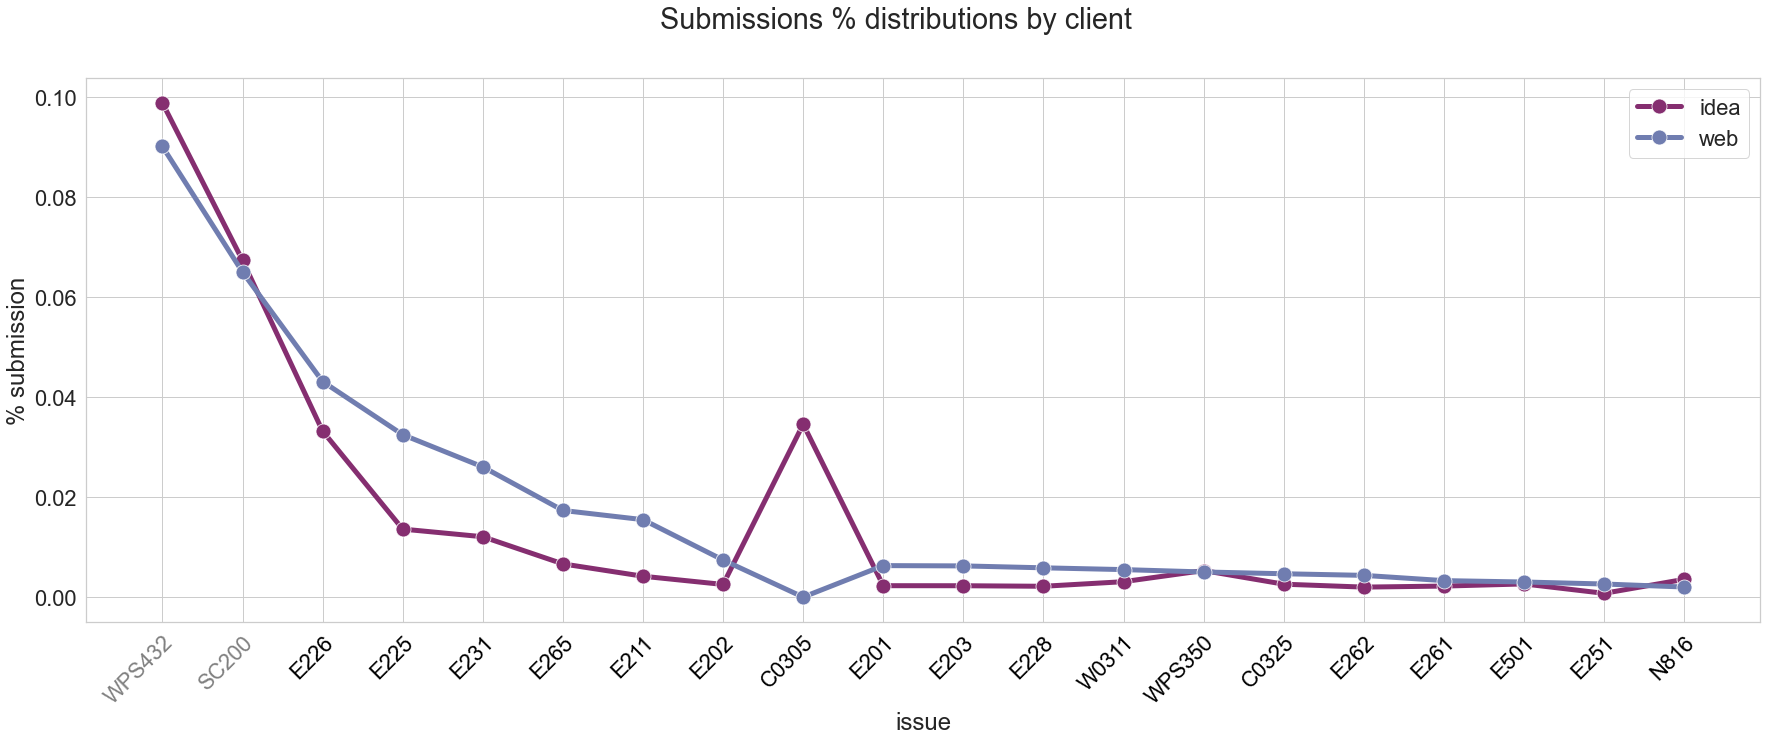

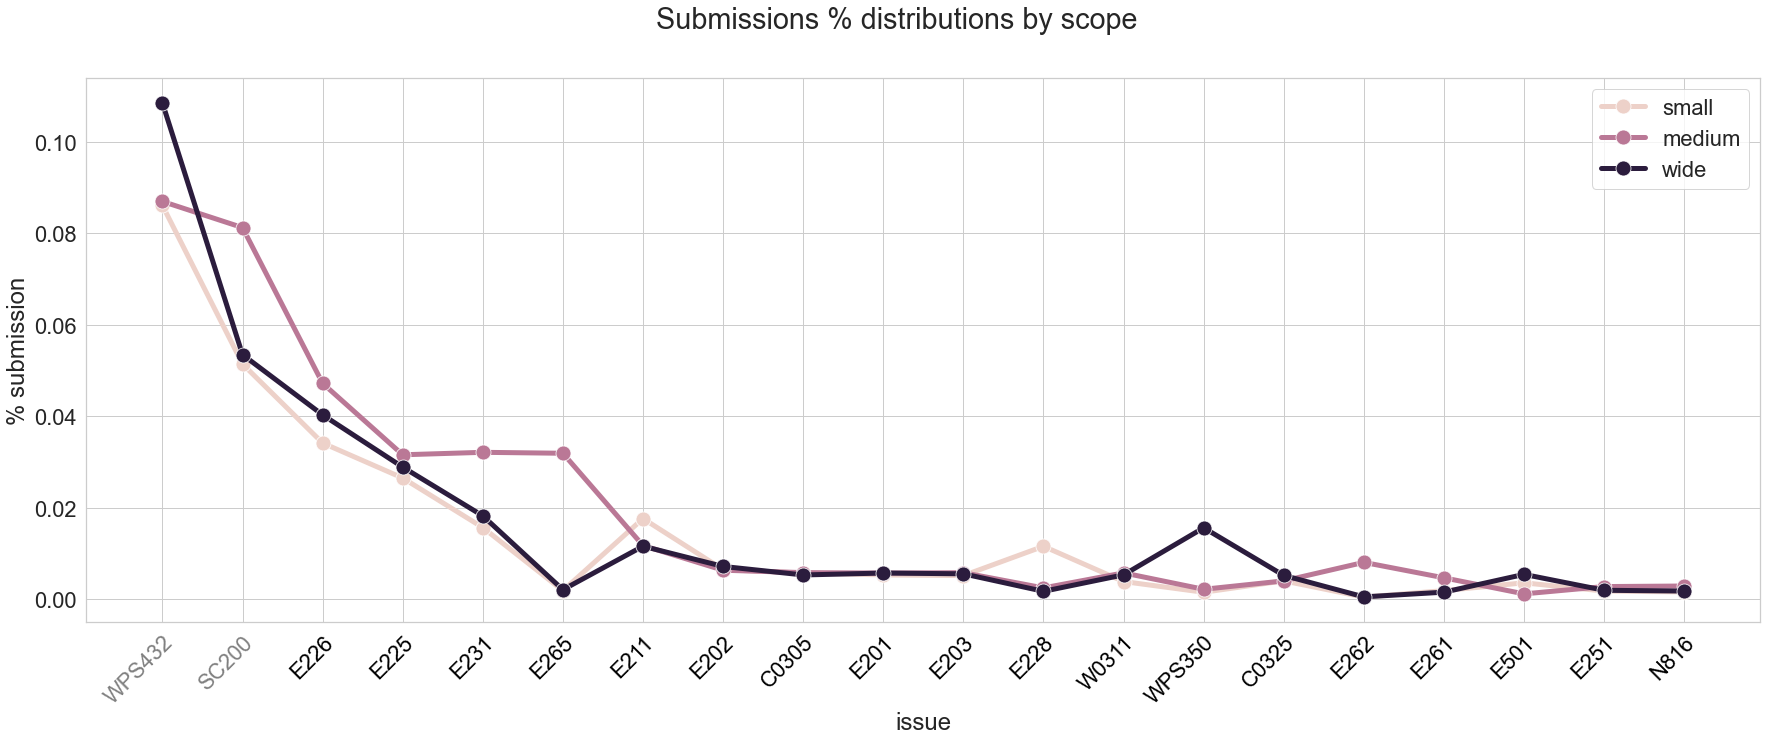

In [48]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_ignore_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=IGNORE_ISSUES_STATS_PATH)

### List and analysis of interesting issues (ERROR_PRONE and BEST_PRACTICES categories)
In further analysis we will consider only top 20 issues with only `ERROR_PRONE` and `BEST_PRACTICES` catecories, other issues are ignored

In [49]:
df_hyperstyle_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_hyperstyle_issues_top.to_csv(os.path.join(ISSUES_STATS_PATH, f'top_issues.csv'), index=False)
df_hyperstyle_issues_top

,name,count,category,text,difficulty,code_sample,ratio
5,WPS336,32062,BEST_PRACTICES,Found explicit string concatenation,MEDIUM,"name = input()\nprint(""Hello, "" + name) # WPS3...",0.023832
10,WPS446,17202,BEST_PRACTICES,Found approximate constant: 2.71,MEDIUM,"print(type(""int""))\nprint(type(394))\nprint(ty...",0.012786
9,WPS223,16584,COMPLEXITY,Found too many `elif` branches: 7 > 3,HARD,"num1, num2, op = float(input()), float(input()...",0.012327
11,WPS462,15740,BEST_PRACTICES,Wrong multiline string usage,MEDIUM,"print(""""""' '' ''' # WPS462 line=1 offset=6\n' ...",0.011700
17,B007,10546,BEST_PRACTICES,Loop control variable 'i' not used within the ...,MEDIUM,n = int(input())\n\nfor i in range(n): # B007 ...,0.007839
16,A001,9885,ERROR_PRONE,"variable ""str"" is shadowing a python builtin",HARD,# put your python code here\nstr = input() # A...,0.007348
13,R1716,8927,BEST_PRACTICES,Simplify chained comparison between the operands,MEDIUM,num = float(input())\n\nif num < 2:\n print...,0.006636
21,WPS345,8188,BEST_PRACTICES,Found meaningless number operation,MEDIUM,print(1*2*3) # WPS345 line=1 offset=7,0.006086
15,WPS237,8063,COMPLEXITY,Found a too complex `f` string,HARD,"word = input()\nprint(f""{word} has {len(word)}...",0.005993
24,WPS519,7914,BEST_PRACTICES,Found implicit `sum()` call,MEDIUM,# put your code here\nn = input()\nresult = 0\...,0.005883


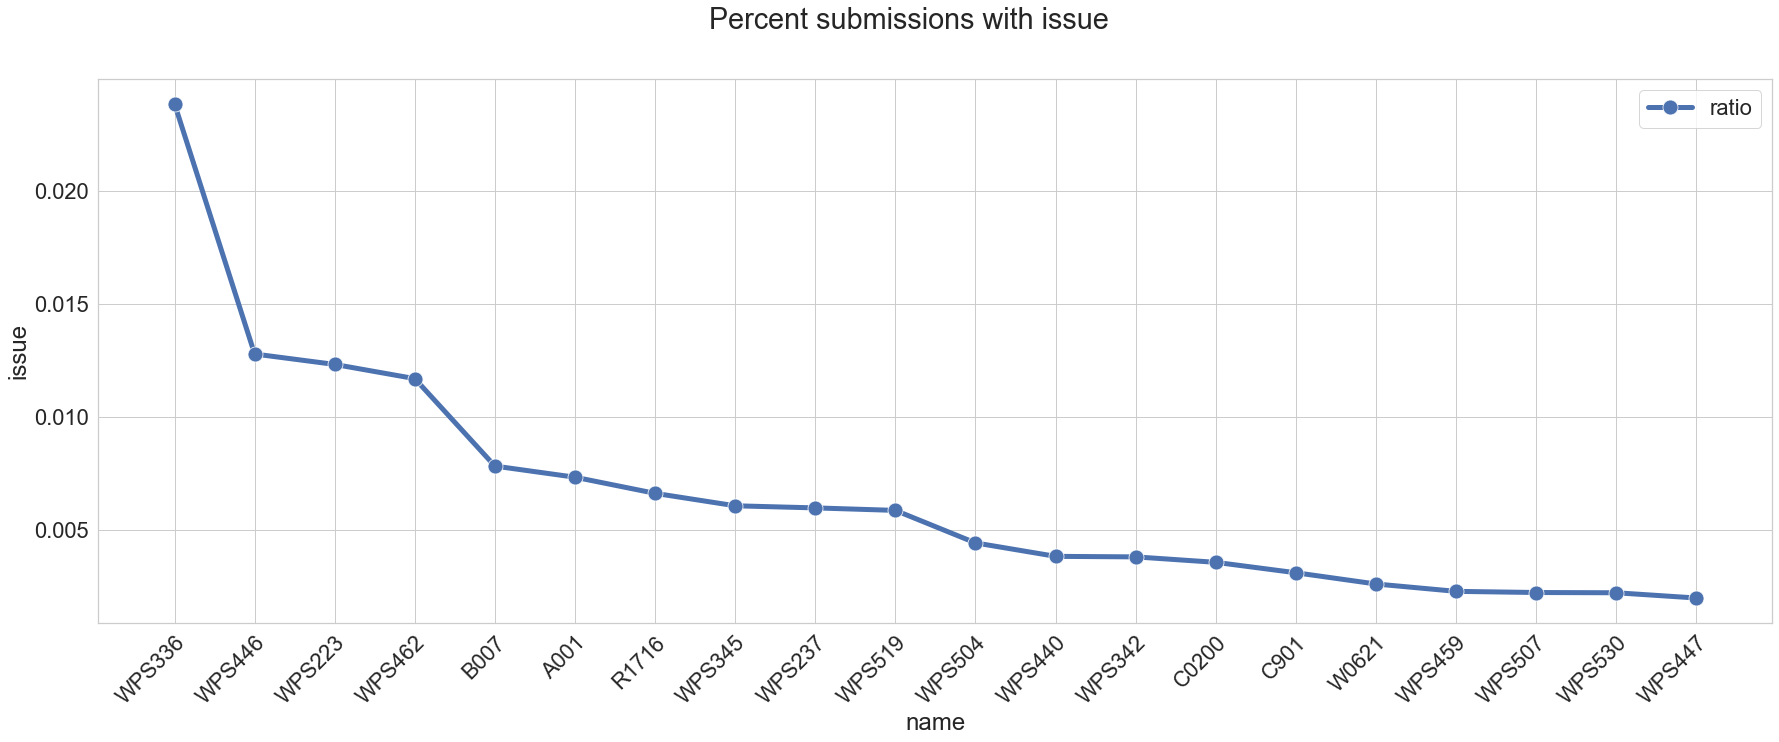

In [50]:
draw_compare(df_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent submissions with issue', 
             save_path=os.path.join(ISSUES_STATS_PATH, f'top_issues.pdf'))

### Percent of all submissions which contain each hyperstyle issue

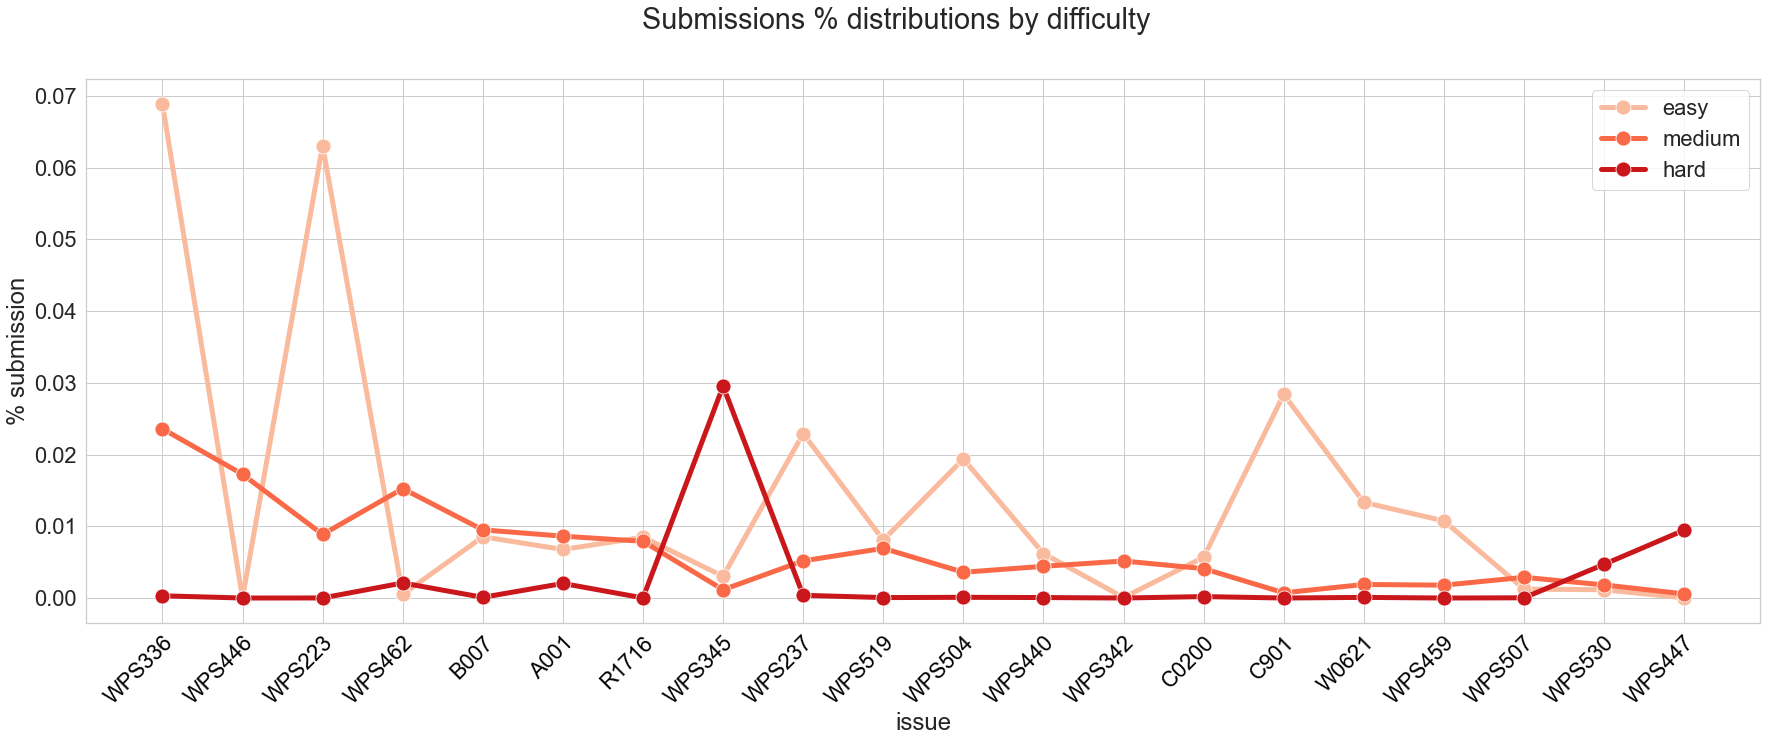

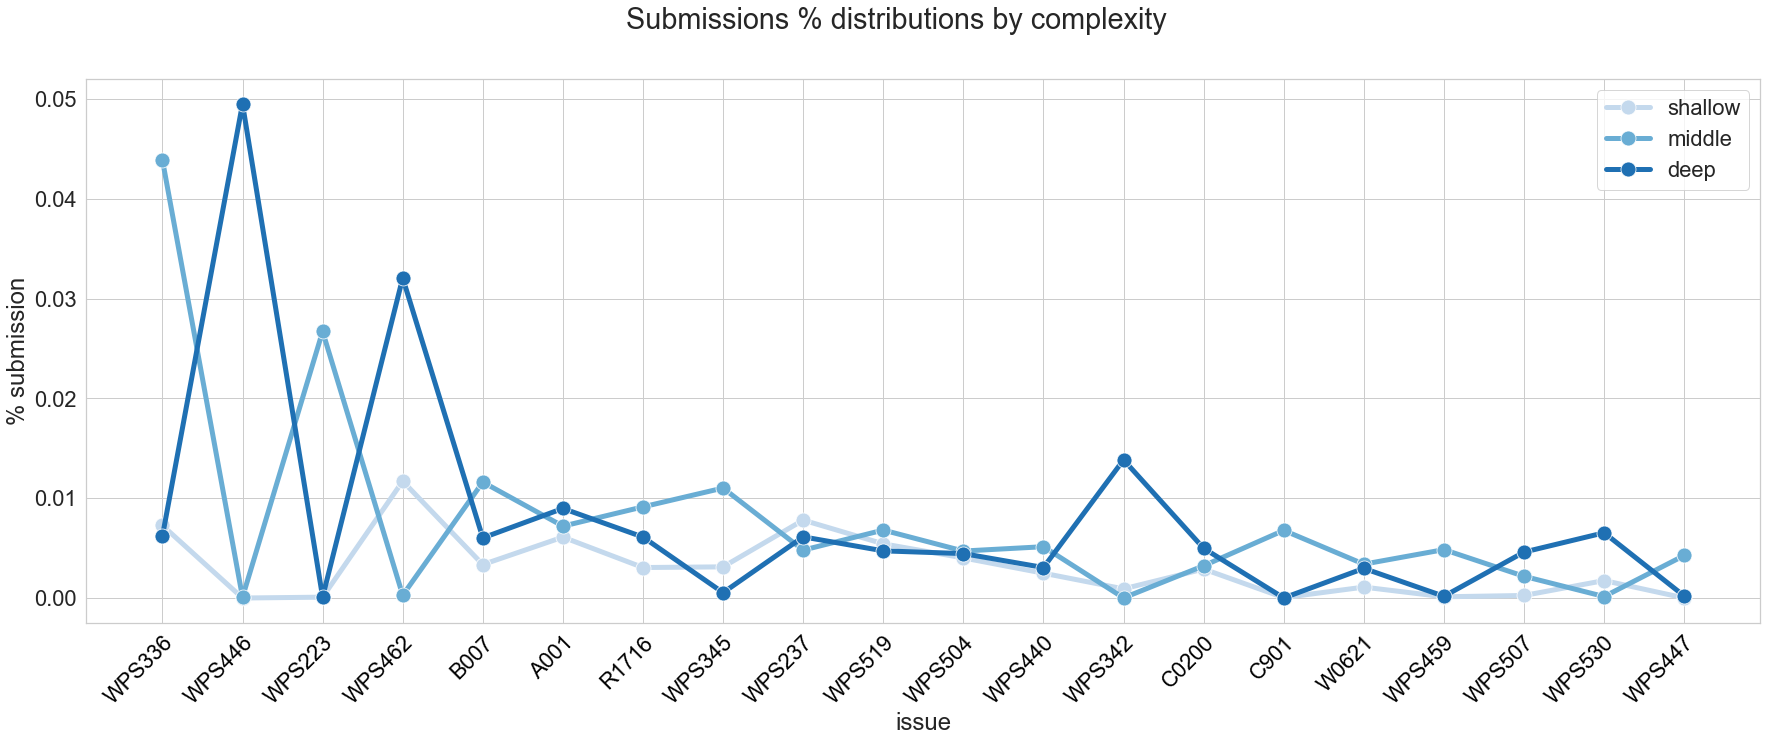

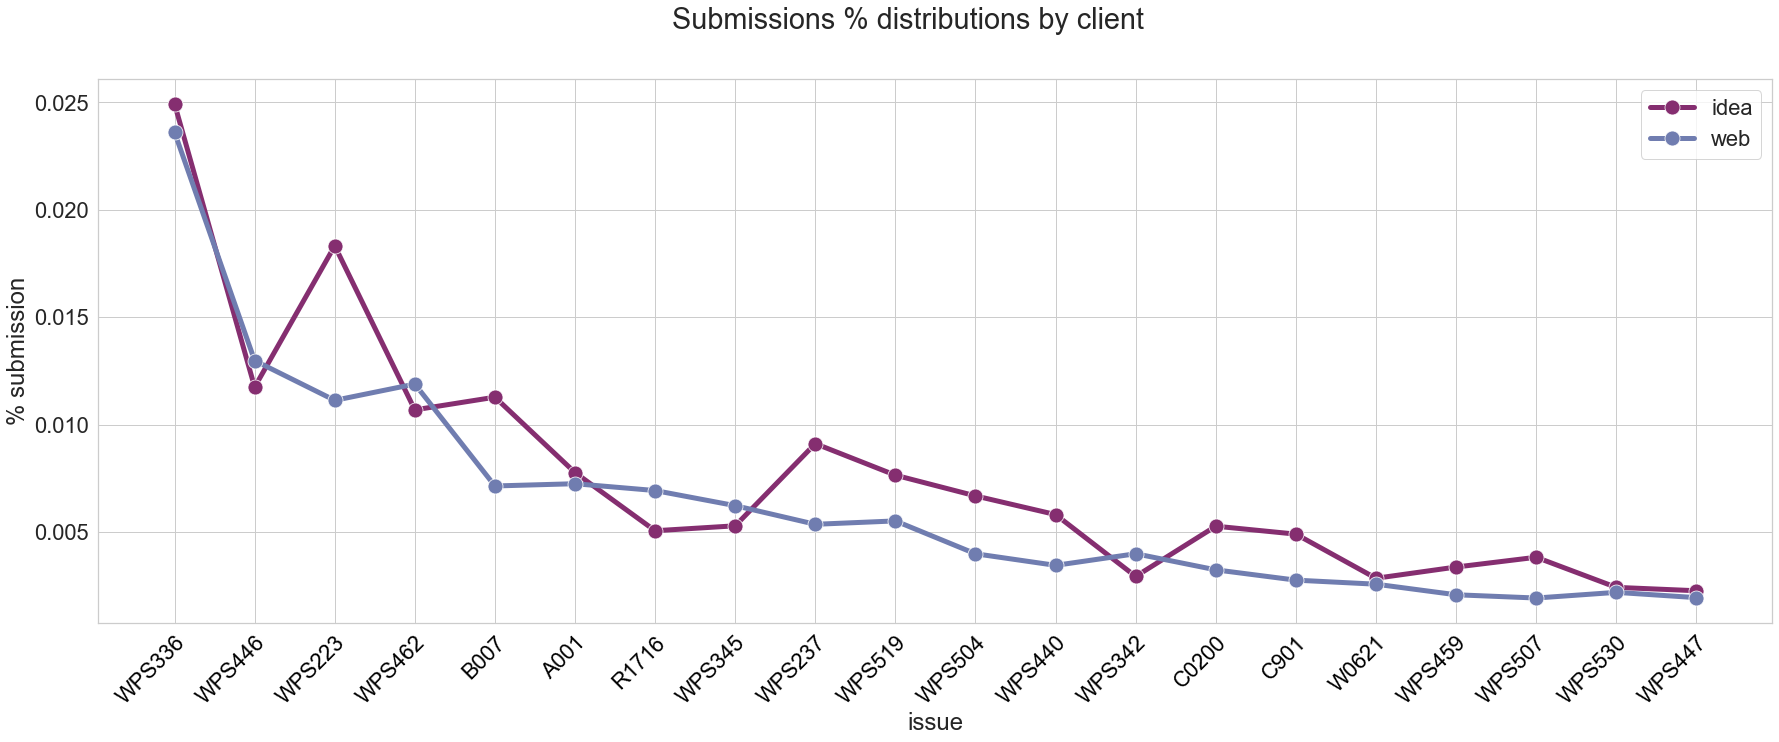

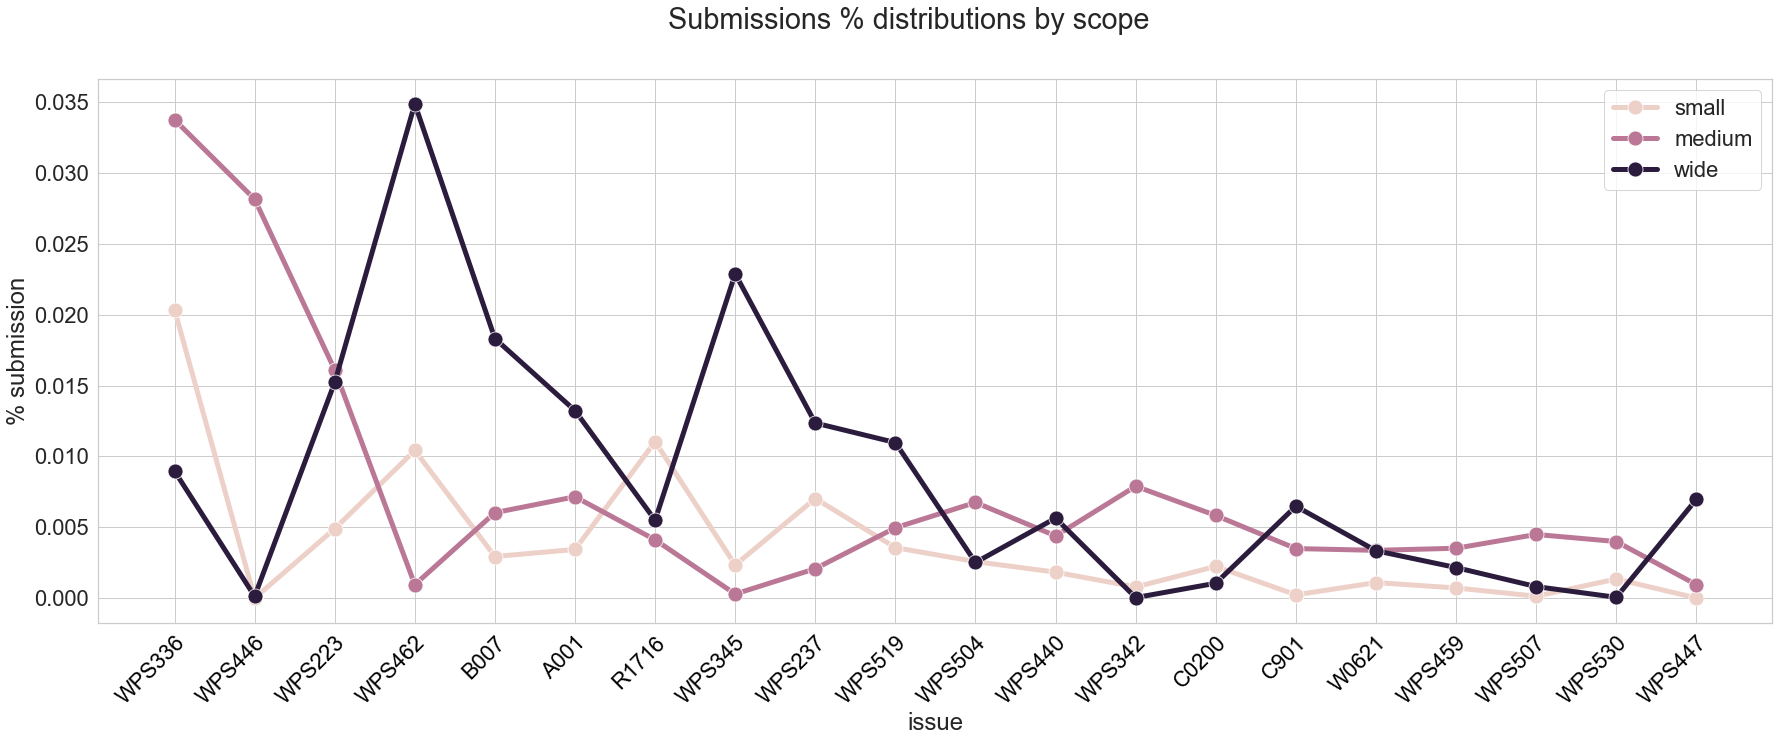

In [51]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=ISSUES_STATS_PATH)

# First attempt stats
First attempt submissions is when **attempt** == 1. This is the most interesting case as student do not see code quality feedback before so 1-st attempt shows the exact level of sudent code quality without any hints.

In [52]:
df_first_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == 1]
df_first_attempt_stats.describe()

,id,code_lines_count,code_symbols_count,step_id,sync_counter,user_id,group,attempt,total_attempts
count,1.152571e+06,1.152571e+06,1.152571e+06,1.152571e+06,1.152571e+06,1.152571e+06,1.152571e+06,1152571.0,1.152571e+06
mean,4.293496e+07,5.043828e+00,1.127612e+02,7.059959e+03,4.772035e+00,5.055958e+04,8.404356e+05,1.0,1.167244e+00
std,7.678092e+06,4.248719e+00,1.112675e+02,1.465047e+03,1.022150e+00,1.620300e+04,4.716168e+05,0.0,5.076292e-01
min,2.938133e+07,1.000000e+00,8.000000e+00,5.205000e+03,2.000000e+00,3.000000e+00,2.000000e+00,1.0,1.000000e+00
25%,3.633995e+07,2.000000e+00,4.400000e+01,6.261000e+03,4.000000e+00,4.333300e+04,4.402585e+05,1.0,1.000000e+00
50%,4.294084e+07,4.000000e+00,7.900000e+01,6.733000e+03,5.000000e+00,5.238600e+04,8.403140e+05,1.0,1.000000e+00
75%,4.968335e+07,7.000000e+00,1.440000e+02,7.199000e+03,5.000000e+00,6.080600e+04,1.227026e+06,1.0,1.000000e+00
max,5.639778e+07,1.280000e+02,4.948000e+03,1.518800e+04,1.900000e+01,8.240000e+04,1.722704e+06,1.0,5.000000e+00


### First attempt statistics

In [53]:
df_first_attempt_hyperstyle_issues_stats = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats, left_on='id', right_on='id')
df_first_attempt_hyperstyle_issues_stats_unique = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats_unique, left_on='id', right_on='id')

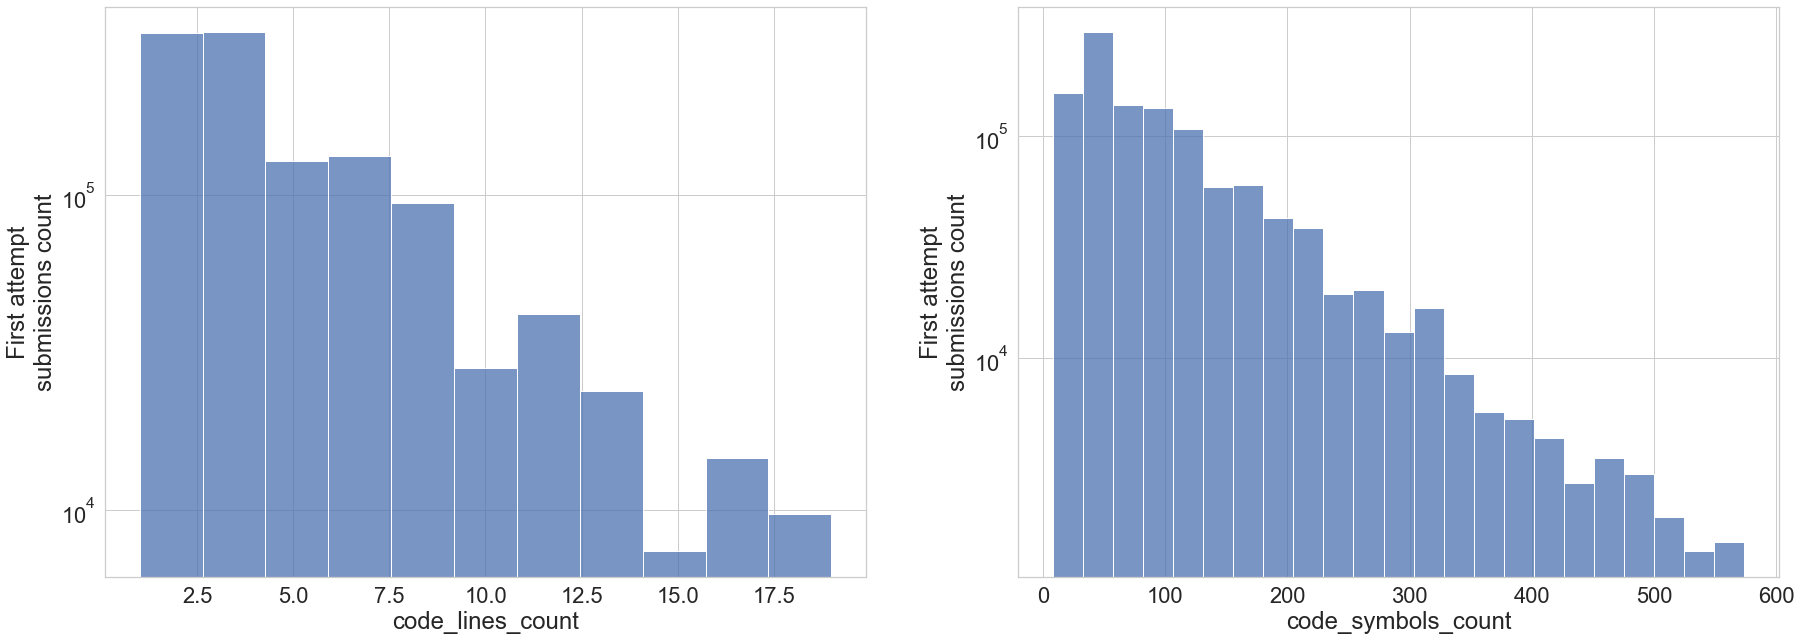

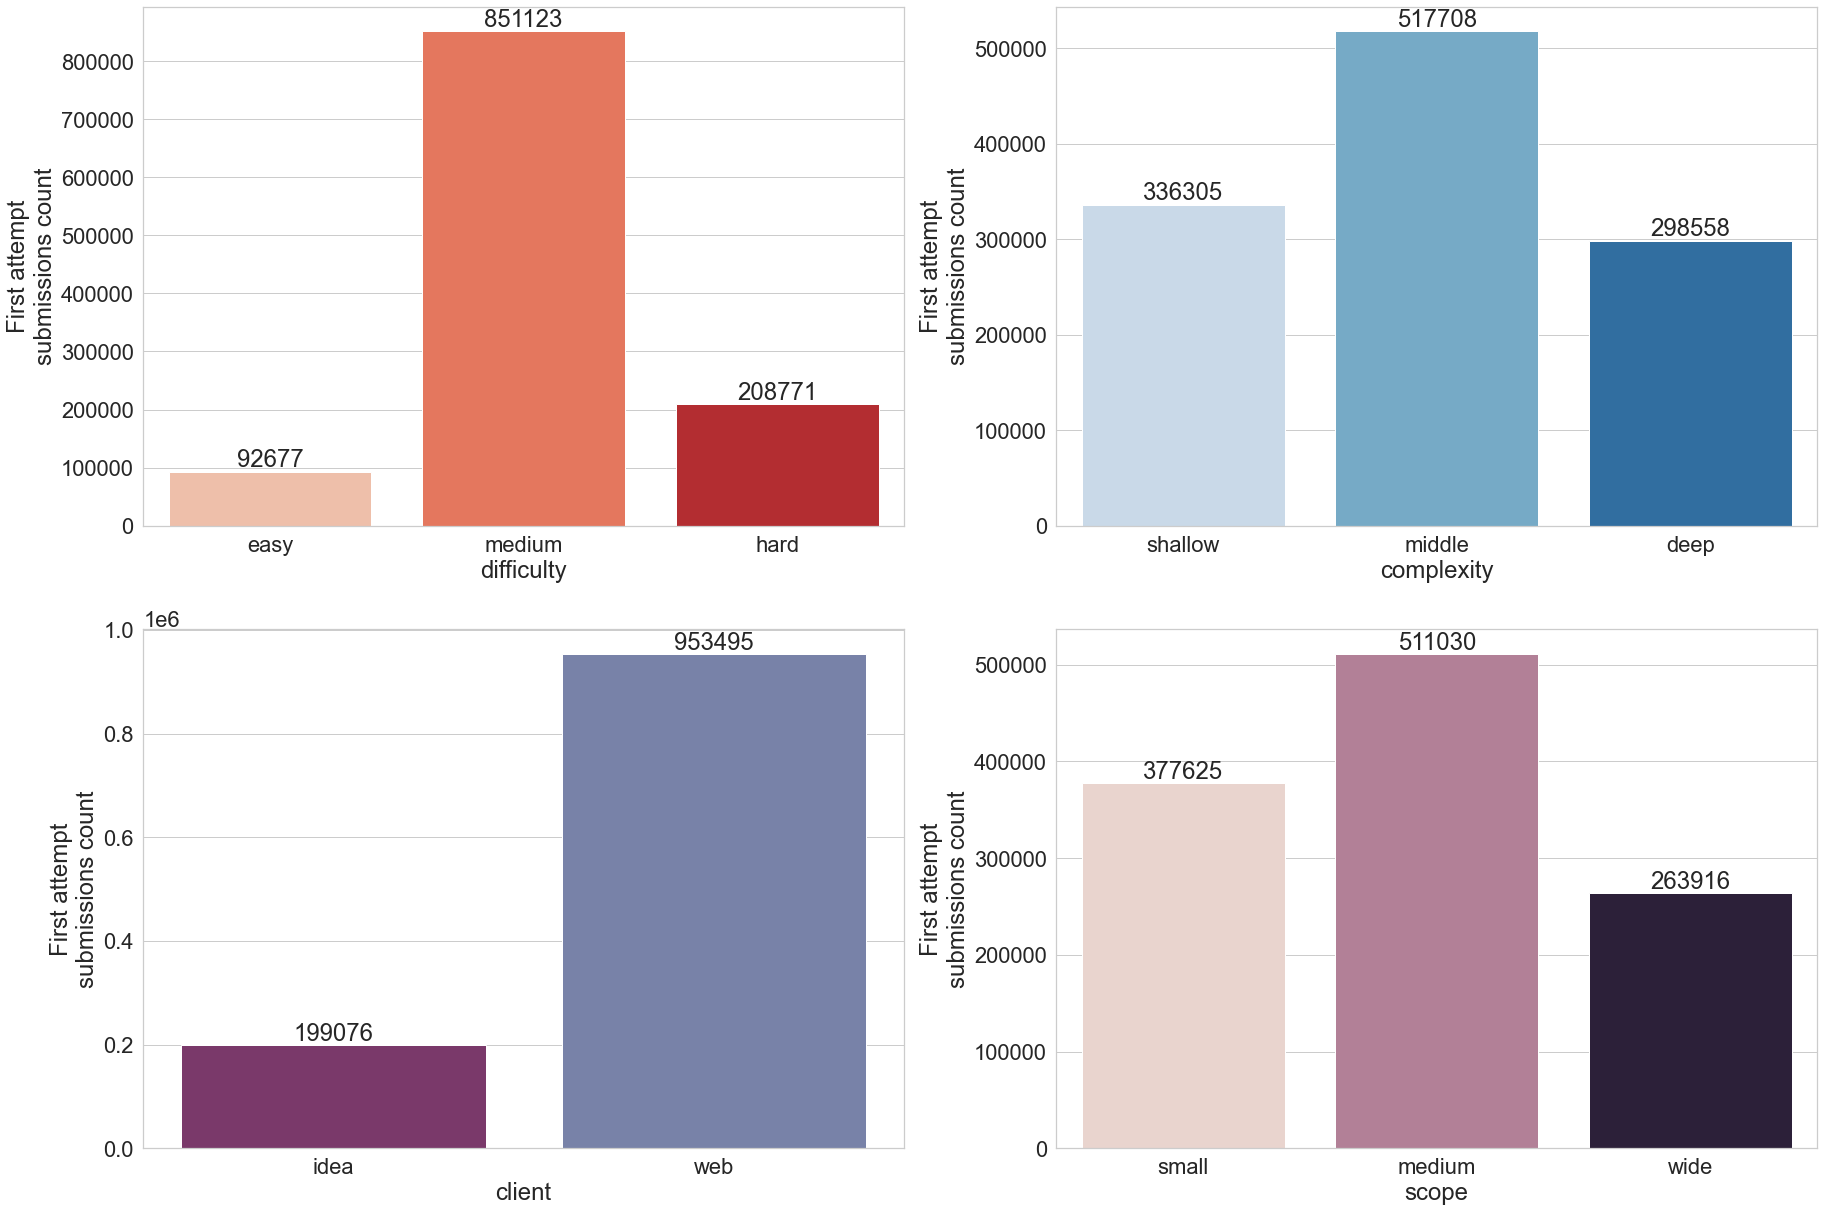

In [54]:
draw_hist_plots(df_first_attempt_hyperstyle_issues_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True), y_label='First attempt\nsubmissions count')

draw_count_plots(df_first_attempt_hyperstyle_issues_stats, ['difficulty', 'complexity', 'client', 'scope'], 
                 y_label='First attempt\nsubmissions count')

In [55]:
df_first_attempt_hyperstyle_issues_top = get_top_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_first_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_first_attempt_hyperstyle_issues_top

,name,count,category,text,difficulty,code_sample,ratio
5,WPS336,25061,BEST_PRACTICES,Found explicit string concatenation,MEDIUM,"name = input()\nprint(""Hello, "" + name) # WPS3...",0.021744
10,WPS446,16650,BEST_PRACTICES,Found approximate constant: 2.71,MEDIUM,"print(type(""int""))\nprint(type(394))\nprint(ty...",0.014446
11,WPS462,14905,BEST_PRACTICES,Wrong multiline string usage,MEDIUM,"print(""""""' '' ''' # WPS462 line=1 offset=6\n' ...",0.012932
9,WPS223,11579,COMPLEXITY,Found too many `elif` branches: 7 > 3,HARD,"num1, num2, op = float(input()), float(input()...",0.010046
17,B007,8333,BEST_PRACTICES,Loop control variable 'i' not used within the ...,MEDIUM,n = int(input())\n\nfor i in range(n): # B007 ...,0.007230
16,A001,7881,ERROR_PRONE,"variable ""str"" is shadowing a python builtin",HARD,# put your python code here\nstr = input() # A...,0.006838
21,WPS345,6832,BEST_PRACTICES,Found meaningless number operation,MEDIUM,print(1*2*3) # WPS345 line=1 offset=7,0.005928
13,R1716,6811,BEST_PRACTICES,Simplify chained comparison between the operands,MEDIUM,num = float(input())\n\nif num < 2:\n print...,0.005909
15,WPS237,6462,COMPLEXITY,Found a too complex `f` string,HARD,"word = input()\nprint(f""{word} has {len(word)}...",0.005607
24,WPS519,5400,BEST_PRACTICES,Found implicit `sum()` call,MEDIUM,# put your code here\nn = input()\nresult = 0\...,0.004685


In [56]:
df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_first_attempt_hyperstyle_issues_stats[df_first_attempt_hyperstyle_issues_top['name'].values].sum(axis=1)

df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count_by_code_lines'] = \
    df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] / \
    df_first_attempt_hyperstyle_issues_stats['code_lines_count']

df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'] = \
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_top['name'].values].sum(axis=1)

df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count_by_code_lines'] = \
    df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'] / \
    df_first_attempt_hyperstyle_issues_stats_unique['code_lines_count']

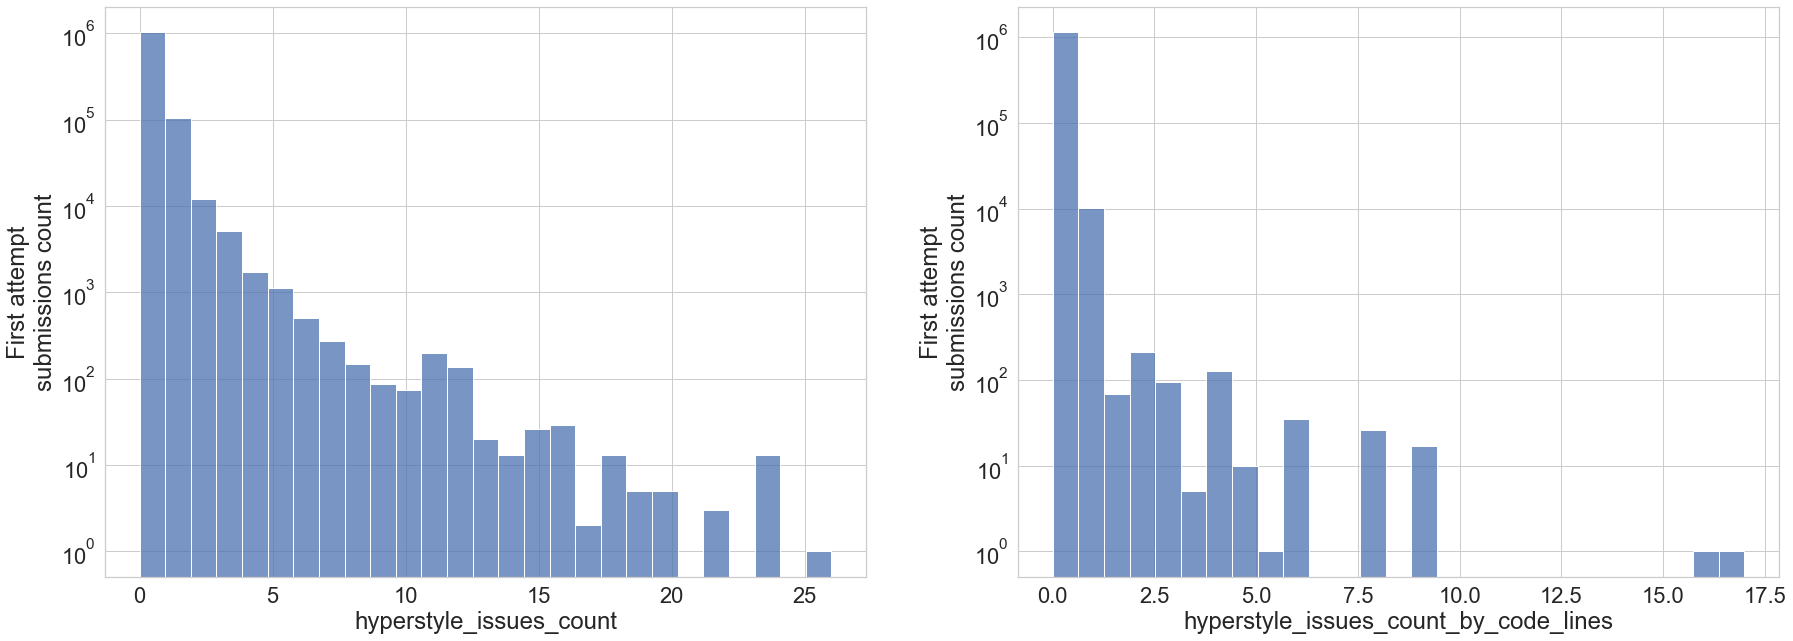

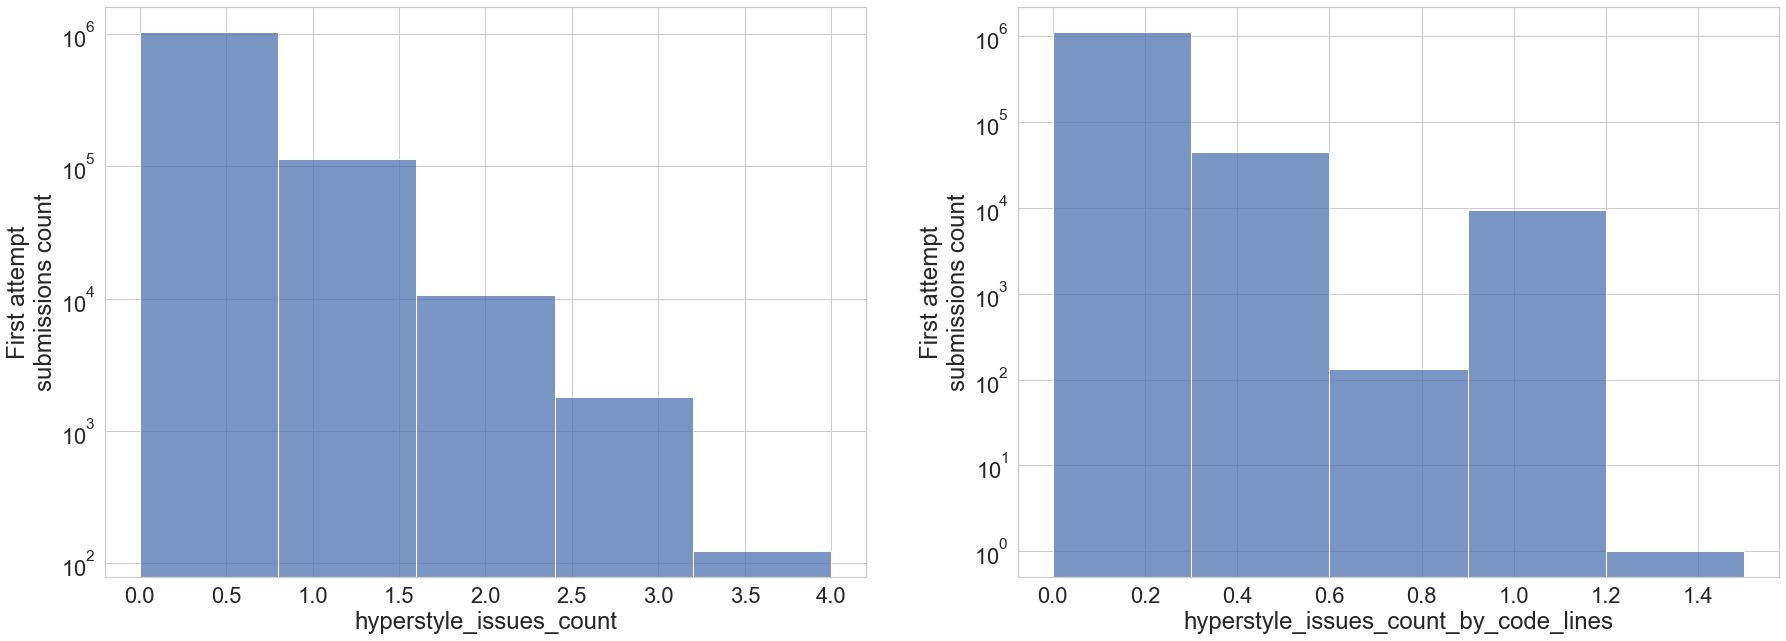

In [57]:
draw_hist_plots(df_first_attempt_hyperstyle_issues_stats, 
                ['hyperstyle_issues_count', 'hyperstyle_issues_count_by_code_lines'], q=1, 
                bins=df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'].max(), 
                log_scale=(False, True),
                y_label='First attempt\nsubmissions count')

draw_hist_plots(df_first_attempt_hyperstyle_issues_stats_unique, 
                ['hyperstyle_issues_count', 'hyperstyle_issues_count_by_code_lines'], q=1, 
                bins=df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'].max(), 
                log_scale=(False, True),
                y_label='First attempt\nsubmissions count')

In [59]:
print('average number of issues in first attempt')
df_first_attempt_hyperstyle_issues_stats[df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] > 0].shape[0] / \
    df_first_attempt_hyperstyle_issues_stats.shape[0]

average number of issues in first attempt


0.10967740815967086

### Hyperstyle issues analysis in first attempt. Percent of submissions with each issue.

In [ ]:
draw_compare(df_first_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent first attempt submissions with issue', 
             save_path=os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

In [ ]:
draw_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
            df_first_attempt_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=FIRST_ATTEMPT_STATS_PATH)

## How many attempts student do depending on number of issues in first submission

In [ ]:
df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'].value_counts()

In [ ]:
df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'].value_counts()

In [ ]:
df_first_attempt_hyperstyle_issues_stats_unique.groupby('hyperstyle_issues_count')['total_attempts'].mean()

In [ ]:
df_first_attempt_hyperstyle_issues_stats.groupby('hyperstyle_issues_count')['total_attempts'].mean()

## Number of total attempts if issues presents in first submission

In [ ]:
print('issue', 'average_attempts')
for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    average_attempts = \
        df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique[issue] > 0]['total_attempts'].mean()
    print(issue, average_attempts)

## Issues/steps correlation

In [ ]:
df_step_issues_correlation = df_first_attempt_hyperstyle_issues_stats_unique \
    .groupby('step_id')[df_first_attempt_hyperstyle_issues_top['name'].values] \
    .mean() \
    .reset_index()

df_step_issues_correlation

In [ ]:
step_issues_dict = {'step_id': [],
                    'issue': [],
                    'ratio': [],
                   }

issues_steps_corr_path = os.path.join(FIRST_ATTEMPT_STATS_PATH, 'issues_steps_corr')
os.makedirs(issues_steps_corr_path, exist_ok=True)

for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    df = df_step_issues_correlation[['step_id', issue]].sort_values(by=issue, ascending=False)
    
    df.to_csv(os.path.join(issues_steps_corr_path, f'{issue}.csv'), index=False)
        
    for _, row in df.iterrows():
        step_issues_dict['step_id'].append(int(row['step_id']))
        step_issues_dict['issue'].append(issue)
        step_issues_dict['ratio'].append(row[issue])

df_step_issues_top = pd.DataFrame.from_dict(step_issues_dict)
df_step_issues_top.to_csv(os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_steps_issues.csv'), index=False)
df_step_issues_top

In [ ]:
issues_steps_dist_path = os.path.join(FIRST_ATTEMPT_STATS_PATH, 'issues_steps_dist')
os.makedirs(issues_steps_dist_path, exist_ok=True)

for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    df = df_first_attempt_hyperstyle_issues_stats_unique[['step_id', issue]] \
            .groupby('step_id') \
            .sum() / df_first_attempt_hyperstyle_issues_stats_unique[issue].sum()
    
    df = df.reset_index()
    df = df[df[issue] > 0].sort_values(by=issue, ascending=False)
    df.to_csv(os.path.join(issues_steps_dist_path, f'{issue}.csv'), index=False)
        
    display(df.T)

# Last attempt stats

Last attempt submissions is when **attempt** == **total_attemps** - final result of all attemps. This shows what issues student do not fix and leave in their final solutions.

In [ ]:
df_last_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == df_submissions_stats['total_attempts']]
df_last_attempt_stats.describe()

In [ ]:
print(df_last_attempt_stats.shape[0] == df_first_attempt_stats.shape[0])

### Last attempt statistics

In [ ]:
draw_hist_plots(df_last_attempt_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True))
draw_count_plots(df_last_attempt_stats, ['difficulty', 'complexity', 'client', 'scope'])

In [ ]:
df_last_attempt_hyperstyle_issues_stats = merge_dfs(df_last_attempt_stats, 
                                                    df_hyperstyle_issues_stats, 
                                                    left_on='id', right_on='id')

df_last_attempt_hyperstyle_issues_stats_unique = merge_dfs(df_last_attempt_stats, 
                                                           df_hyperstyle_issues_stats_unique, 
                                                           left_on='id', right_on='id')

### Hyperstyle issues analysis in last attempt. Percent of submissions with each issue.

In [ ]:
def sort_by_order(df: pd.DataFrame, column: str, order: List[str]) -> pd.DataFrame:
    df_order = pd.DataFrame.from_dict({'order': order})
    return merge_dfs(df_order, df, left_on='order', right_on=column).drop(columns=['order'])

In [ ]:
df_last_attempt_hyperstyle_issues_top = get_top_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          len(df_hyperstyle_issues), 
                                          hyperstyle_issues_ignore_names)

df_last_attempt_hyperstyle_issues_top = sort_by_order(df_last_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_last_attempt_hyperstyle_issues_top

In [ ]:
draw_compare(df_last_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent last attempt submissions with issue', 
             save_path=os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

In [ ]:
draw_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=LAST_ATTEMPT_STATS_PATH)

In [ ]:
df_single_attempt_hyperstyle_issues_top = get_top_issues(
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'] == 1],
    df_hyperstyle_issues, 
    len(df_first_attempt_hyperstyle_issues_top), 
    hyperstyle_issues_ignore_names)

df_single_attempt_hyperstyle_issues_top = sort_by_order(df_single_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_single_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                            f'single_attempt_top_issues.csv'), index=False)
df_single_attempt_hyperstyle_issues_top

In [ ]:
df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    df_last_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    left_on=['name', 'category'], right_on=['name', 'category'], suffixes=('_first', '_last'))

df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_last_attempt_hyperstyle_issues_top, 
    df_single_attempt_hyperstyle_issues_top[['name', 'count', 'category']].rename(
        columns={'count': 'count_single_attempt', 'ratio': 'ratio_single_attempt'}),
    left_on=['name', 'category'], right_on=['name', 'category'])

df_first_last_attempt_hyperstyle_issues_top

In [ ]:
df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']

df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']
    
df_first_last_attempt_hyperstyle_issues_top['count_diff'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single']

df_first_last_attempt_hyperstyle_issues_top['ratio_left'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] / \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single']

df_first_last_attempt_hyperstyle_issues_top = df_first_last_attempt_hyperstyle_issues_top \
    .sort_values(by='ratio_left')

df_first_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                                f'top_issues.csv'), index=False)
df_first_last_attempt_hyperstyle_issues_top

In [ ]:
draw_compare(df_first_last_attempt_hyperstyle_issues_top, 
             'name', ['ratio', ['ratio_left']], 
             y_label='issue', 
             title='Percent of issues left in last submissions', 
             save_path=os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

# Submission series (groups) analysis
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**. In this section you can find analysis of the student progess on code quality issues fixing. 

### Number of submission series by total number of attempts in series

In [ ]:
df_last_attempt_stats['total_attempts'].value_counts()[:20]

In [ ]:
def draw_feature_dynamic(feature: str, max_attempts: int = 5, exact_attempts: bool = False, is_mean=True):
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_hyperstyle_issues_stats, feature, attr, 
                                                               max_attempts=max_attempts)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

## Average number of hyperstyle issues by each attempt
For all submission series, we calculate mean number of issues made on i-th attempt. The plots show that from attempt to attempt the number of issues in students’ solutions decreases, regardless of the parameters of the student, steps on environment.

`exact_attempts` - if True than only submissions with `total_attempt` == `max_attempts` (so the number of submission for each attempt is equal) are selected othwise `total_attempt` <= `max_attempts` (so the number of submission for each attempt is decreasing)

In [ ]:
df_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_hyperstyle_issues_stats[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats['hyperstyle_issues_count'].value_counts()

In [ ]:
draw_feature_dynamic('hyperstyle_issues_count', max_attempts=3, exact_attempts=True)

## Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 5

In [ ]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 5,
                                          exact_attempts: bool = False, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, max_attempts, exact_attempts, 
                                                              by_type, is_mean)
    suffix = f'{max_attempts}' + ('_by_type' if by_type else '') + ('_exect' if exact_attempts else '')
    
    df_issues_dynamic.drop(columns=['attempt', 'count']).T \
        .to_csv(os.path.join(ISSUES_DYNAMIC_STATS_PATH, f'issues_dynamic_{suffix}.csv'), index=True)
    
    issues = df_issues['category' if by_type else 'name'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))
    return df_issues_dynamic.drop(columns=['attempt', 'count']).T

### Hypertyle issues dynamic by attempts (with issue names)
Percent of submission which contains each issue by attempts dynamic. The plot shows that in most cases all issues are decreras but it should be examined more precisely in csv file

In [ ]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    max_attempts=3, 
                    exact_attempts=True)

In [ ]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    by_type=True, 
                    max_attempts=3, 
                    exact_attempts=True)

In [ ]:
df_hyperstyle_issues_stats_unique['hypertysle_issues_count'] = \
    df_hyperstyle_issues_stats_unique[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats_unique['hypertysle_issues_count'].value_counts()

In [ ]:
df_last_attempt_hyperstyle_issues_top = get_top_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          len(df_hyperstyle_issues), 
                                          hyperstyle_issues_ignore_names)

df_last_attempt_hyperstyle_issues_top = sort_by_order(df_last_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_last_attempt_hyperstyle_issues_top

In [ ]:
draw_compare(df_last_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent last attempt submissions with issue', 
             save_path=os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

In [ ]:
draw_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=LAST_ATTEMPT_STATS_PATH)

In [ ]:
df_single_attempt_hyperstyle_issues_top = get_top_issues(
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'] == 1],
    df_hyperstyle_issues, 
    len(df_first_attempt_hyperstyle_issues_top), 
    hyperstyle_issues_ignore_names)

df_single_attempt_hyperstyle_issues_top = sort_by_order(df_single_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_single_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                            f'single_attempt_top_issues.csv'), index=False)
df_single_attempt_hyperstyle_issues_top

In [ ]:
df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    df_last_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    left_on=['name', 'category'], right_on=['name', 'category'], suffixes=('_first', '_last'))

df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_last_attempt_hyperstyle_issues_top, 
    df_single_attempt_hyperstyle_issues_top[['name', 'count', 'category']].rename(
        columns={'count': 'count_single_attempt', 'ratio': 'ratio_single_attempt'}),
    left_on=['name', 'category'], right_on=['name', 'category'])

df_first_last_attempt_hyperstyle_issues_top

In [ ]:
df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']

df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']
    
df_first_last_attempt_hyperstyle_issues_top['count_diff'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single']

df_first_last_attempt_hyperstyle_issues_top['ratio_left'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] / \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single']

df_first_last_attempt_hyperstyle_issues_top = df_first_last_attempt_hyperstyle_issues_top \
    .sort_values(by='ratio_left')

df_first_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                                f'top_issues.csv'), index=False)
df_first_last_attempt_hyperstyle_issues_top

In [ ]:
draw_compare(df_first_last_attempt_hyperstyle_issues_top, 
             'name', ['ratio', ['ratio_left']], 
             y_label='issue', 
             title='Percent of issues left in last submissions', 
             save_path=os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

# Submission series (groups) analysis
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**. In this section you can find analysis of the student progess on code quality issues fixing. 

### Number of submission series by total number of attempts in series

In [ ]:
df_last_attempt_stats['total_attempts'].value_counts()[:20]

In [ ]:
def draw_feature_dynamic(feature: str, max_attempts: int = 5, exact_attempts: bool = False, is_mean=True):
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_hyperstyle_issues_stats, feature, attr, 
                                                               max_attempts=max_attempts)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

## Average number of hyperstyle issues by each attempt
For all submission series, we calculate mean number of issues made on i-th attempt. The plots show that from attempt to attempt the number of issues in students’ solutions decreases, regardless of the parameters of the student, steps on environment.

`exact_attempts` - if True than only submissions with `total_attempt` == `max_attempts` (so the number of submission for each attempt is equal) are selected othwise `total_attempt` <= `max_attempts` (so the number of submission for each attempt is decreasing)

In [ ]:
df_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_hyperstyle_issues_stats[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats['hyperstyle_issues_count'].value_counts()

In [ ]:
draw_feature_dynamic('hyperstyle_issues_count', max_attempts=3, exact_attempts=True)

## Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 5

In [ ]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 5,
                                          exact_attempts: bool = False, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, max_attempts, exact_attempts, 
                                                              by_type, is_mean)
    suffix = f'{max_attempts}' + ('_by_type' if by_type else '') + ('_exect' if exact_attempts else '')
    
    df_issues_dynamic.drop(columns=['attempt', 'count']).T \
        .to_csv(os.path.join(ISSUES_DYNAMIC_STATS_PATH, f'issues_dynamic_{suffix}.csv'), index=True)
    
    issues = df_issues['category' if by_type else 'name'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))
    return df_issues_dynamic.drop(columns=['attempt', 'count']).T

### Hypertyle issues dynamic by attempts (with issue names)
Percent of submission which contains each issue by attempts dynamic. The plot shows that in most cases all issues are decreras but it should be examined more precisely in csv file

In [ ]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    max_attempts=3, 
                    exact_attempts=True)

In [ ]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    by_type=True, 
                    max_attempts=3, 
                    exact_attempts=True)

In [ ]:
df_hyperstyle_issues_stats_unique['hypertysle_issues_count'] = \
    df_hyperstyle_issues_stats_unique[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats_unique['hypertysle_issues_count'].value_counts()